### Classify Humans based on activities from sensor recordings (Accelerometer). 
The dataset is available https://archive.ics.uci.edu/ml/datasets/User+Identification+From+Walking+Activity

In [0]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from io import StringIO
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline


#### Load json file to read from GCS

In [23]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./datadownloader.json"

In [0]:
from google.cloud import storage
data = pd.DataFrame()

def get_data():
  data=pd.DataFrame()
  client = storage.Client()
  bucket = client.get_bucket('vkasth-t2t')
  for i in range(1,23):
    blob = storage.Blob('Activity/%s.csv' % i, bucket)
    content = blob.download_as_string()
    df = pd.read_csv(StringIO(unicode(content, 'utf-8')),names=['time_step','x','y', 'z'],header=None)
    df['label'] = i
    data = data.append(df)

  data = data.reset_index().drop('index', axis=1)
  return data

data = get_data()

### Explore Data
Trend show how there are differences in variances of these individual readings along x,y,z

In [26]:
data.head()

,time_step,x,y,z,label
0,0.000000,0.69464,3.17350,7.5048,1
1,0.030639,0.14982,3.48680,9.2755,1
2,0.069763,-0.29965,1.94770,9.1120,1
3,0.099823,-1.68890,1.41650,10.1200,1
4,0.129820,-2.17930,0.95342,10.9240,1


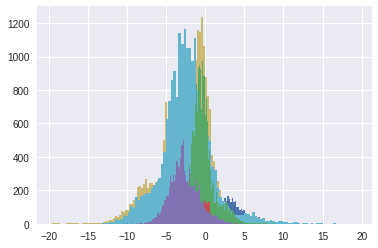

In [27]:
a = data.groupby('label').x.hist(alpha=0.4, bins=100)

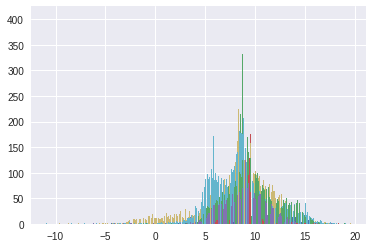

In [28]:
b = data.groupby('label').y.hist(alpha=0.4, bins=1000)

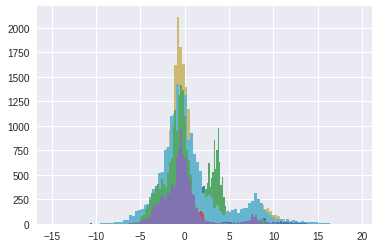

In [29]:
c = data.groupby('label').z.hist(alpha=0.4, bins=100)

#### Scale data

In [0]:
X=data[['x','y','z']]
scaler=MinMaxScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X))
X_scaled.columns = ['x_scaled', 'y_scaled', 'z_scaled']

In [0]:
data = data.join(X_scaled)

#### Explore data to visualize time series for each individual
Observe that the patterns are similar across the x,y,z but these patterns vary with for each user

In [0]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([0,1])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(person, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['time_step'], data['x_scaled'], 'x_scaled')
    plot_axis(ax1, data['time_step'], data['y_scaled'], 'y_scaled')
    plot_axis(ax2, data['time_step'], data['z_scaled'], 'z_scaled')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(person)
    plt.subplots_adjust(top=0.90)
    plt.show()

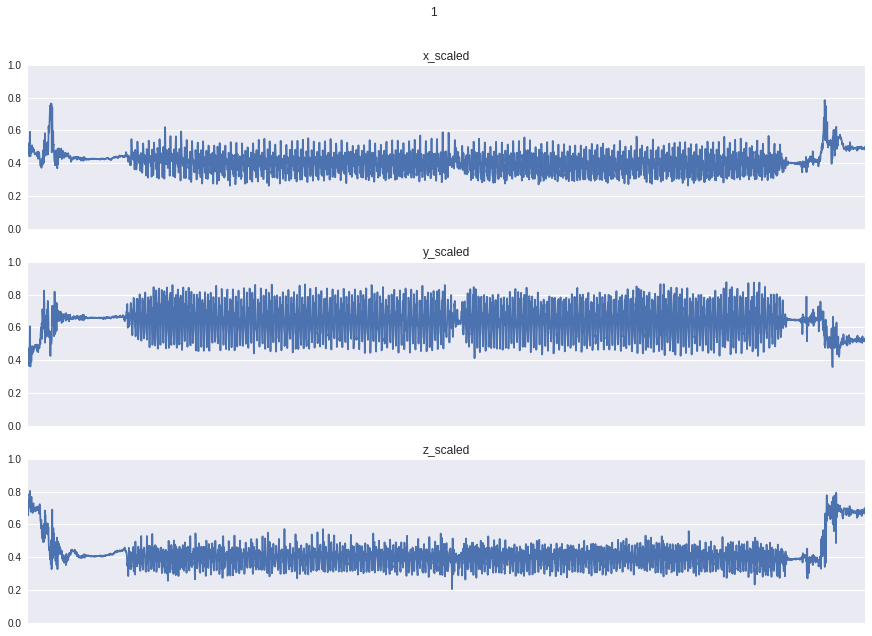

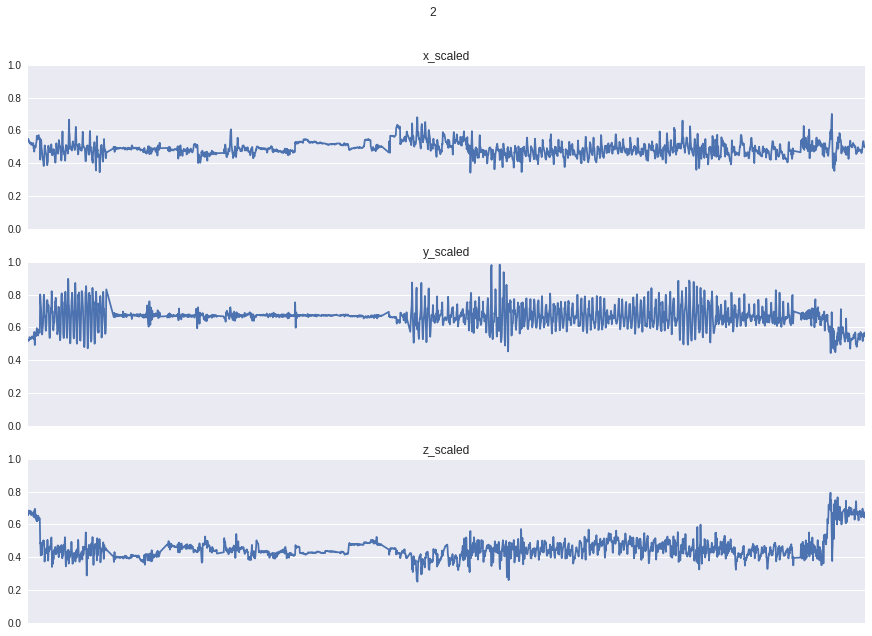

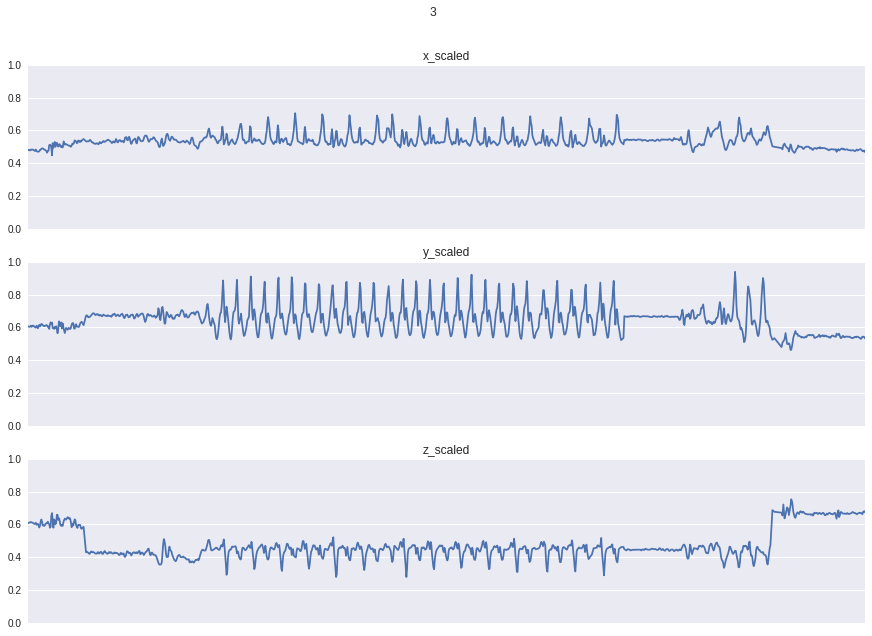

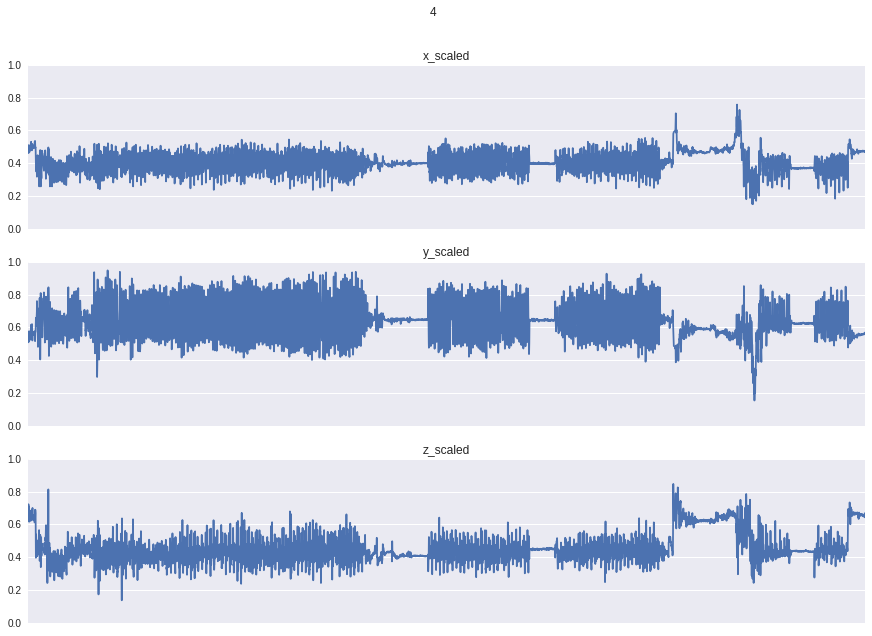

In [33]:
for i in range(1,5):
  plot_activity(i, data.loc[data['label']==i,])

#### Number of datapoints for each user
Observe that number of readings for each user is different with the lowest being 911 and highest as ~22k

In [34]:
[(data.loc[data['label'] == i,:].shape) for i in range(1,23)]

[(5069, 8),
 (3882, 8),
 (1144, 8),
 (6981, 8),
 (1129, 8),
 (4936, 8),
 (3729, 8),
 (3457, 8),
 (7988, 8),
 (3086, 8),
 (5636, 8),
 (4799, 8),
 (6699, 8),
 (12027, 8),
 (3653, 8),
 (1728, 8),
 (21991, 8),
 (20758, 8),
 (911, 8),
 (16949, 8),
 (3082, 8),
 (9698, 8)]

#### Create windows to segment the time series into window of readings that could be fed to an LSTM cell
Choosing a window size of 500 (500 tiume steps for each input) - This will require 500 LSTM cells when unfolded for the encoder.

In [0]:
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

##### Test

In [15]:
for start, end in windows(data.loc[data['label'] == 2,:], 500):

ValueError: ignored

In [0]:
def window_signals(data,window_size = 500):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data["time_step"], window_size):
        x = data["x_scaled"][start:end]
        y = data["y_scaled"][start:end]
        z = data["z_scaled"][start:end]
        if(len(data["time_step"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["label"][start:end])[0][0])
    return segments, labels

In [0]:
segments, labels = window_signals(data)

Creates segments with 596 readings with 500 time steps for each reading along with the class label

In [38]:
segments.shape

(596, 500, 3)

In [39]:
labels.shape

(596,)

In [0]:
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)

In [41]:
labels.shape

(596, 22)

#### Create train validation split

In [0]:
X_train, X_vld, y_train, y_vld = train_test_split(segments, labels, 
                                                stratify = labels,
                                                random_state = 123)

In [22]:
X_train.shape

(447, 500, 3)

In [23]:
X_vld.shape

(149, 500, 3)

#### Define the hyperparameters for the LSTM model (many to one)
Choose the number of neurons in each LSTM layer to be at least 3 times the number of channels.
Choosing 2 layers of neurons for Each RNNCell
A batch size of 100 is used for convergence (should be less than train and valid)
Sequence length is the size of the sequence. These are the number of cells to unfold to.
Choosing 2000 epochs for wait to convergence

In [0]:
lstm_size = 9         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 100       # Batch size
seq_len = 500          # Number of steps
learning_rate = 0.0001  # Learning rate (default is 0.001)
epochs = 5000

# Fixed
n_classes = 22
n_channels = 3

#### Setup the graph
create placeholders for inputs, labels, keep probability, learning_rates.



In [0]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

#### Build the graph further
Key to transform the input initially to seq, ?, channel as you would want to want to split it to ? (batchsize), channel size while using tf.split
Flatten the inputs and split them into equal lengths of seq lengths. Add the LSTM layers, dropout wrapper, and cover it with a MutiRNNCell and set the initial state

In [0]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

#### Output, Cost and Loss functions
Set the output cell, specify cost function along with cross entropy loss. Use AdamOptimzer, and use grandient clips for vanishing gradients issue. Also compute the accuracy

In [0]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [0]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [0]:
def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

### Train and validate the model

In [58]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_train, y_train, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%25 == 0):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/lstm2.ckpt")

('Epoch: 1/5000', 'Iteration: 5', 'Train loss: 3.126235', 'Train acc: 0.040000')
('Epoch: 2/5000', 'Iteration: 10', 'Train loss: 3.104797', 'Train acc: 0.030000')
('Epoch: 3/5000', 'Iteration: 15', 'Train loss: 3.113700', 'Train acc: 0.050000')
('Epoch: 4/5000', 'Iteration: 20', 'Train loss: 3.115581', 'Train acc: 0.050000')
('Epoch: 6/5000', 'Iteration: 25', 'Train loss: 3.097910', 'Train acc: 0.030000')
('Epoch: 6/5000', 'Iteration: 25', 'Validation loss: 3.100580', 'Validation acc: 0.040000')
('Epoch: 7/5000', 'Iteration: 30', 'Train loss: 3.109987', 'Train acc: 0.030000')
('Epoch: 8/5000', 'Iteration: 35', 'Train loss: 3.107153', 'Train acc: 0.020000')
('Epoch: 9/5000', 'Iteration: 40', 'Train loss: 3.093248', 'Train acc: 0.040000')
('Epoch: 11/5000', 'Iteration: 45', 'Train loss: 3.090791', 'Train acc: 0.040000')
('Epoch: 12/5000', 'Iteration: 50', 'Train loss: 3.089090', 'Train acc: 0.030000')
('Epoch: 12/5000', 'Iteration: 50', 'Validation loss: 3.092527', 'Validation acc: 0.080

('Epoch: 51/5000', 'Iteration: 205', 'Train loss: 3.040012', 'Train acc: 0.110000')
('Epoch: 52/5000', 'Iteration: 210', 'Train loss: 3.027069', 'Train acc: 0.100000')
('Epoch: 53/5000', 'Iteration: 215', 'Train loss: 3.054044', 'Train acc: 0.080000')
('Epoch: 54/5000', 'Iteration: 220', 'Train loss: 3.046666', 'Train acc: 0.050000')
('Epoch: 56/5000', 'Iteration: 225', 'Train loss: 3.033358', 'Train acc: 0.140000')
('Epoch: 56/5000', 'Iteration: 225', 'Validation loss: 3.021716', 'Validation acc: 0.150000')
('Epoch: 57/5000', 'Iteration: 230', 'Train loss: 3.054508', 'Train acc: 0.110000')
('Epoch: 58/5000', 'Iteration: 235', 'Train loss: 3.066499', 'Train acc: 0.070000')
('Epoch: 59/5000', 'Iteration: 240', 'Train loss: 3.040744', 'Train acc: 0.070000')
('Epoch: 61/5000', 'Iteration: 245', 'Train loss: 3.008195', 'Train acc: 0.090000')
('Epoch: 62/5000', 'Iteration: 250', 'Train loss: 3.012489', 'Train acc: 0.060000')
('Epoch: 62/5000', 'Iteration: 250', 'Validation loss: 3.005600', 

('Epoch: 99/5000', 'Iteration: 400', 'Validation loss: 2.911658', 'Validation acc: 0.150000')
('Epoch: 101/5000', 'Iteration: 405', 'Train loss: 2.945661', 'Train acc: 0.130000')
('Epoch: 102/5000', 'Iteration: 410', 'Train loss: 2.957461', 'Train acc: 0.150000')
('Epoch: 103/5000', 'Iteration: 415', 'Train loss: 3.065772', 'Train acc: 0.100000')
('Epoch: 104/5000', 'Iteration: 420', 'Train loss: 2.977785', 'Train acc: 0.120000')
('Epoch: 106/5000', 'Iteration: 425', 'Train loss: 2.912782', 'Train acc: 0.150000')
('Epoch: 106/5000', 'Iteration: 425', 'Validation loss: 2.903072', 'Validation acc: 0.150000')
('Epoch: 107/5000', 'Iteration: 430', 'Train loss: 2.929798', 'Train acc: 0.130000')
('Epoch: 108/5000', 'Iteration: 435', 'Train loss: 2.952414', 'Train acc: 0.160000')
('Epoch: 109/5000', 'Iteration: 440', 'Train loss: 2.961894', 'Train acc: 0.140000')
('Epoch: 111/5000', 'Iteration: 445', 'Train loss: 2.925282', 'Train acc: 0.100000')
('Epoch: 112/5000', 'Iteration: 450', 'Train l

('Epoch: 149/5000', 'Iteration: 600', 'Train loss: 2.912984', 'Train acc: 0.120000')
('Epoch: 149/5000', 'Iteration: 600', 'Validation loss: 2.863543', 'Validation acc: 0.150000')
('Epoch: 151/5000', 'Iteration: 605', 'Train loss: 2.888513', 'Train acc: 0.150000')
('Epoch: 152/5000', 'Iteration: 610', 'Train loss: 2.905229', 'Train acc: 0.190000')
('Epoch: 153/5000', 'Iteration: 615', 'Train loss: 2.956688', 'Train acc: 0.120000')
('Epoch: 154/5000', 'Iteration: 620', 'Train loss: 2.912358', 'Train acc: 0.050000')
('Epoch: 156/5000', 'Iteration: 625', 'Train loss: 2.902250', 'Train acc: 0.150000')
('Epoch: 156/5000', 'Iteration: 625', 'Validation loss: 2.859792', 'Validation acc: 0.150000')
('Epoch: 157/5000', 'Iteration: 630', 'Train loss: 2.855004', 'Train acc: 0.160000')
('Epoch: 158/5000', 'Iteration: 635', 'Train loss: 2.924936', 'Train acc: 0.130000')
('Epoch: 159/5000', 'Iteration: 640', 'Train loss: 2.923314', 'Train acc: 0.110000')
('Epoch: 161/5000', 'Iteration: 645', 'Train 

('Epoch: 198/5000', 'Iteration: 795', 'Train loss: 2.953772', 'Train acc: 0.120000')
('Epoch: 199/5000', 'Iteration: 800', 'Train loss: 2.878252', 'Train acc: 0.120000')
('Epoch: 199/5000', 'Iteration: 800', 'Validation loss: 2.842155', 'Validation acc: 0.150000')
('Epoch: 201/5000', 'Iteration: 805', 'Train loss: 2.860872', 'Train acc: 0.170000')
('Epoch: 202/5000', 'Iteration: 810', 'Train loss: 2.850032', 'Train acc: 0.140000')
('Epoch: 203/5000', 'Iteration: 815', 'Train loss: 2.985981', 'Train acc: 0.090000')
('Epoch: 204/5000', 'Iteration: 820', 'Train loss: 2.920754', 'Train acc: 0.060000')
('Epoch: 206/5000', 'Iteration: 825', 'Train loss: 2.835297', 'Train acc: 0.090000')
('Epoch: 206/5000', 'Iteration: 825', 'Validation loss: 2.840208', 'Validation acc: 0.150000')
('Epoch: 207/5000', 'Iteration: 830', 'Train loss: 2.811947', 'Train acc: 0.170000')
('Epoch: 208/5000', 'Iteration: 835', 'Train loss: 2.973469', 'Train acc: 0.100000')
('Epoch: 209/5000', 'Iteration: 840', 'Train 

('Epoch: 247/5000', 'Iteration: 990', 'Train loss: 2.866861', 'Train acc: 0.120000')
('Epoch: 248/5000', 'Iteration: 995', 'Train loss: 2.953012', 'Train acc: 0.110000')
('Epoch: 249/5000', 'Iteration: 1000', 'Train loss: 2.857707', 'Train acc: 0.080000')
('Epoch: 249/5000', 'Iteration: 1000', 'Validation loss: 2.828619', 'Validation acc: 0.150000')
('Epoch: 251/5000', 'Iteration: 1005', 'Train loss: 2.832013', 'Train acc: 0.120000')
('Epoch: 252/5000', 'Iteration: 1010', 'Train loss: 2.792144', 'Train acc: 0.130000')
('Epoch: 253/5000', 'Iteration: 1015', 'Train loss: 2.975394', 'Train acc: 0.090000')
('Epoch: 254/5000', 'Iteration: 1020', 'Train loss: 2.873043', 'Train acc: 0.130000')
('Epoch: 256/5000', 'Iteration: 1025', 'Train loss: 2.858902', 'Train acc: 0.140000')
('Epoch: 256/5000', 'Iteration: 1025', 'Validation loss: 2.827421', 'Validation acc: 0.150000')
('Epoch: 257/5000', 'Iteration: 1030', 'Train loss: 2.902199', 'Train acc: 0.110000')
('Epoch: 258/5000', 'Iteration: 1035

('Epoch: 296/5000', 'Iteration: 1185', 'Train loss: 2.811811', 'Train acc: 0.150000')
('Epoch: 297/5000', 'Iteration: 1190', 'Train loss: 2.884722', 'Train acc: 0.090000')
('Epoch: 298/5000', 'Iteration: 1195', 'Train loss: 2.894241', 'Train acc: 0.140000')
('Epoch: 299/5000', 'Iteration: 1200', 'Train loss: 2.858098', 'Train acc: 0.110000')
('Epoch: 299/5000', 'Iteration: 1200', 'Validation loss: 2.820049', 'Validation acc: 0.150000')
('Epoch: 301/5000', 'Iteration: 1205', 'Train loss: 2.898918', 'Train acc: 0.100000')
('Epoch: 302/5000', 'Iteration: 1210', 'Train loss: 2.845723', 'Train acc: 0.090000')
('Epoch: 303/5000', 'Iteration: 1215', 'Train loss: 2.914651', 'Train acc: 0.090000')
('Epoch: 304/5000', 'Iteration: 1220', 'Train loss: 2.888048', 'Train acc: 0.110000')
('Epoch: 306/5000', 'Iteration: 1225', 'Train loss: 2.804569', 'Train acc: 0.190000')
('Epoch: 306/5000', 'Iteration: 1225', 'Validation loss: 2.819166', 'Validation acc: 0.150000')
('Epoch: 307/5000', 'Iteration: 12

('Epoch: 344/5000', 'Iteration: 1380', 'Train loss: 2.877939', 'Train acc: 0.150000')
('Epoch: 346/5000', 'Iteration: 1385', 'Train loss: 2.801757', 'Train acc: 0.150000')
('Epoch: 347/5000', 'Iteration: 1390', 'Train loss: 2.841338', 'Train acc: 0.130000')
('Epoch: 348/5000', 'Iteration: 1395', 'Train loss: 2.916734', 'Train acc: 0.130000')
('Epoch: 349/5000', 'Iteration: 1400', 'Train loss: 2.833197', 'Train acc: 0.140000')
('Epoch: 349/5000', 'Iteration: 1400', 'Validation loss: 2.812962', 'Validation acc: 0.150000')
('Epoch: 351/5000', 'Iteration: 1405', 'Train loss: 2.831409', 'Train acc: 0.170000')
('Epoch: 352/5000', 'Iteration: 1410', 'Train loss: 2.831368', 'Train acc: 0.160000')
('Epoch: 353/5000', 'Iteration: 1415', 'Train loss: 2.935413', 'Train acc: 0.110000')
('Epoch: 354/5000', 'Iteration: 1420', 'Train loss: 2.834102', 'Train acc: 0.180000')
('Epoch: 356/5000', 'Iteration: 1425', 'Train loss: 2.795442', 'Train acc: 0.170000')
('Epoch: 356/5000', 'Iteration: 1425', 'Vali

('Epoch: 393/5000', 'Iteration: 1575', 'Validation loss: 2.808563', 'Validation acc: 0.150000')
('Epoch: 394/5000', 'Iteration: 1580', 'Train loss: 2.815084', 'Train acc: 0.060000')
('Epoch: 396/5000', 'Iteration: 1585', 'Train loss: 2.871049', 'Train acc: 0.130000')
('Epoch: 397/5000', 'Iteration: 1590', 'Train loss: 2.857120', 'Train acc: 0.140000')
('Epoch: 398/5000', 'Iteration: 1595', 'Train loss: 2.909183', 'Train acc: 0.110000')
('Epoch: 399/5000', 'Iteration: 1600', 'Train loss: 2.816240', 'Train acc: 0.160000')
('Epoch: 399/5000', 'Iteration: 1600', 'Validation loss: 2.808192', 'Validation acc: 0.150000')
('Epoch: 401/5000', 'Iteration: 1605', 'Train loss: 2.782291', 'Train acc: 0.170000')
('Epoch: 402/5000', 'Iteration: 1610', 'Train loss: 2.897765', 'Train acc: 0.100000')
('Epoch: 403/5000', 'Iteration: 1615', 'Train loss: 2.928904', 'Train acc: 0.090000')
('Epoch: 404/5000', 'Iteration: 1620', 'Train loss: 2.827920', 'Train acc: 0.090000')
('Epoch: 406/5000', 'Iteration: 16

('Epoch: 443/5000', 'Iteration: 1775', 'Train loss: 2.880764', 'Train acc: 0.110000')
('Epoch: 443/5000', 'Iteration: 1775', 'Validation loss: 2.805582', 'Validation acc: 0.150000')
('Epoch: 444/5000', 'Iteration: 1780', 'Train loss: 2.856549', 'Train acc: 0.130000')
('Epoch: 446/5000', 'Iteration: 1785', 'Train loss: 2.797907', 'Train acc: 0.200000')
('Epoch: 447/5000', 'Iteration: 1790', 'Train loss: 2.858368', 'Train acc: 0.100000')
('Epoch: 448/5000', 'Iteration: 1795', 'Train loss: 2.878086', 'Train acc: 0.120000')
('Epoch: 449/5000', 'Iteration: 1800', 'Train loss: 2.827387', 'Train acc: 0.080000')
('Epoch: 449/5000', 'Iteration: 1800', 'Validation loss: 2.805307', 'Validation acc: 0.150000')
('Epoch: 451/5000', 'Iteration: 1805', 'Train loss: 2.788339', 'Train acc: 0.130000')
('Epoch: 452/5000', 'Iteration: 1810', 'Train loss: 2.829763', 'Train acc: 0.190000')
('Epoch: 453/5000', 'Iteration: 1815', 'Train loss: 2.905125', 'Train acc: 0.120000')
('Epoch: 454/5000', 'Iteration: 18

('Epoch: 492/5000', 'Iteration: 1970', 'Train loss: 2.825424', 'Train acc: 0.140000')
('Epoch: 493/5000', 'Iteration: 1975', 'Train loss: 2.911411', 'Train acc: 0.100000')
('Epoch: 493/5000', 'Iteration: 1975', 'Validation loss: 2.804462', 'Validation acc: 0.150000')
('Epoch: 494/5000', 'Iteration: 1980', 'Train loss: 2.810857', 'Train acc: 0.110000')
('Epoch: 496/5000', 'Iteration: 1985', 'Train loss: 2.786976', 'Train acc: 0.160000')
('Epoch: 497/5000', 'Iteration: 1990', 'Train loss: 2.812662', 'Train acc: 0.130000')
('Epoch: 498/5000', 'Iteration: 1995', 'Train loss: 2.912850', 'Train acc: 0.100000')
('Epoch: 499/5000', 'Iteration: 2000', 'Train loss: 2.815813', 'Train acc: 0.100000')
('Epoch: 499/5000', 'Iteration: 2000', 'Validation loss: 2.804340', 'Validation acc: 0.150000')
('Epoch: 501/5000', 'Iteration: 2005', 'Train loss: 2.770610', 'Train acc: 0.190000')
('Epoch: 502/5000', 'Iteration: 2010', 'Train loss: 2.819019', 'Train acc: 0.160000')
('Epoch: 503/5000', 'Iteration: 20

('Epoch: 541/5000', 'Iteration: 2165', 'Train loss: 2.832022', 'Train acc: 0.130000')
('Epoch: 542/5000', 'Iteration: 2170', 'Train loss: 2.811708', 'Train acc: 0.170000')
('Epoch: 543/5000', 'Iteration: 2175', 'Train loss: 2.908656', 'Train acc: 0.150000')
('Epoch: 543/5000', 'Iteration: 2175', 'Validation loss: 2.802406', 'Validation acc: 0.150000')
('Epoch: 544/5000', 'Iteration: 2180', 'Train loss: 2.833552', 'Train acc: 0.180000')
('Epoch: 546/5000', 'Iteration: 2185', 'Train loss: 2.781772', 'Train acc: 0.130000')
('Epoch: 547/5000', 'Iteration: 2190', 'Train loss: 2.848180', 'Train acc: 0.150000')
('Epoch: 548/5000', 'Iteration: 2195', 'Train loss: 2.883138', 'Train acc: 0.080000')
('Epoch: 549/5000', 'Iteration: 2200', 'Train loss: 2.790292', 'Train acc: 0.170000')
('Epoch: 549/5000', 'Iteration: 2200', 'Validation loss: 2.802478', 'Validation acc: 0.150000')
('Epoch: 551/5000', 'Iteration: 2205', 'Train loss: 2.830852', 'Train acc: 0.160000')
('Epoch: 552/5000', 'Iteration: 22

('Epoch: 589/5000', 'Iteration: 2360', 'Train loss: 2.834004', 'Train acc: 0.110000')
('Epoch: 591/5000', 'Iteration: 2365', 'Train loss: 2.807575', 'Train acc: 0.130000')
('Epoch: 592/5000', 'Iteration: 2370', 'Train loss: 2.757246', 'Train acc: 0.120000')
('Epoch: 593/5000', 'Iteration: 2375', 'Train loss: 2.913876', 'Train acc: 0.080000')
('Epoch: 593/5000', 'Iteration: 2375', 'Validation loss: 2.800710', 'Validation acc: 0.160000')
('Epoch: 594/5000', 'Iteration: 2380', 'Train loss: 2.849440', 'Train acc: 0.100000')
('Epoch: 596/5000', 'Iteration: 2385', 'Train loss: 2.809760', 'Train acc: 0.120000')
('Epoch: 597/5000', 'Iteration: 2390', 'Train loss: 2.790736', 'Train acc: 0.110000')
('Epoch: 598/5000', 'Iteration: 2395', 'Train loss: 2.910160', 'Train acc: 0.110000')
('Epoch: 599/5000', 'Iteration: 2400', 'Train loss: 2.795413', 'Train acc: 0.140000')
('Epoch: 599/5000', 'Iteration: 2400', 'Validation loss: 2.800452', 'Validation acc: 0.200000')
('Epoch: 601/5000', 'Iteration: 24

('Epoch: 638/5000', 'Iteration: 2555', 'Train loss: 2.851363', 'Train acc: 0.150000')
('Epoch: 639/5000', 'Iteration: 2560', 'Train loss: 2.818183', 'Train acc: 0.180000')
('Epoch: 641/5000', 'Iteration: 2565', 'Train loss: 2.834528', 'Train acc: 0.120000')
('Epoch: 642/5000', 'Iteration: 2570', 'Train loss: 2.804708', 'Train acc: 0.130000')
('Epoch: 643/5000', 'Iteration: 2575', 'Train loss: 2.892974', 'Train acc: 0.110000')
('Epoch: 643/5000', 'Iteration: 2575', 'Validation loss: 2.793288', 'Validation acc: 0.150000')
('Epoch: 644/5000', 'Iteration: 2580', 'Train loss: 2.820292', 'Train acc: 0.090000')
('Epoch: 646/5000', 'Iteration: 2585', 'Train loss: 2.759612', 'Train acc: 0.160000')
('Epoch: 647/5000', 'Iteration: 2590', 'Train loss: 2.792942', 'Train acc: 0.210000')
('Epoch: 648/5000', 'Iteration: 2595', 'Train loss: 2.833843', 'Train acc: 0.120000')
('Epoch: 649/5000', 'Iteration: 2600', 'Train loss: 2.819976', 'Train acc: 0.090000')
('Epoch: 649/5000', 'Iteration: 2600', 'Vali

('Epoch: 687/5000', 'Iteration: 2750', 'Validation loss: 2.786136', 'Validation acc: 0.120000')
('Epoch: 688/5000', 'Iteration: 2755', 'Train loss: 2.850043', 'Train acc: 0.150000')
('Epoch: 689/5000', 'Iteration: 2760', 'Train loss: 2.829095', 'Train acc: 0.160000')
('Epoch: 691/5000', 'Iteration: 2765', 'Train loss: 2.721402', 'Train acc: 0.190000')
('Epoch: 692/5000', 'Iteration: 2770', 'Train loss: 2.819603', 'Train acc: 0.180000')
('Epoch: 693/5000', 'Iteration: 2775', 'Train loss: 2.831413', 'Train acc: 0.080000')
('Epoch: 693/5000', 'Iteration: 2775', 'Validation loss: 2.784672', 'Validation acc: 0.120000')
('Epoch: 694/5000', 'Iteration: 2780', 'Train loss: 2.827114', 'Train acc: 0.160000')
('Epoch: 696/5000', 'Iteration: 2785', 'Train loss: 2.760240', 'Train acc: 0.150000')
('Epoch: 697/5000', 'Iteration: 2790', 'Train loss: 2.795146', 'Train acc: 0.150000')
('Epoch: 698/5000', 'Iteration: 2795', 'Train loss: 2.892546', 'Train acc: 0.120000')
('Epoch: 699/5000', 'Iteration: 28

('Epoch: 737/5000', 'Iteration: 2950', 'Train loss: 2.793104', 'Train acc: 0.120000')
('Epoch: 737/5000', 'Iteration: 2950', 'Validation loss: 2.785447', 'Validation acc: 0.120000')
('Epoch: 738/5000', 'Iteration: 2955', 'Train loss: 2.837382', 'Train acc: 0.170000')
('Epoch: 739/5000', 'Iteration: 2960', 'Train loss: 2.820240', 'Train acc: 0.130000')
('Epoch: 741/5000', 'Iteration: 2965', 'Train loss: 2.757043', 'Train acc: 0.200000')
('Epoch: 742/5000', 'Iteration: 2970', 'Train loss: 2.803095', 'Train acc: 0.120000')
('Epoch: 743/5000', 'Iteration: 2975', 'Train loss: 2.898695', 'Train acc: 0.100000')
('Epoch: 743/5000', 'Iteration: 2975', 'Validation loss: 2.781553', 'Validation acc: 0.120000')
('Epoch: 744/5000', 'Iteration: 2980', 'Train loss: 2.796906', 'Train acc: 0.130000')
('Epoch: 746/5000', 'Iteration: 2985', 'Train loss: 2.727140', 'Train acc: 0.160000')
('Epoch: 747/5000', 'Iteration: 2990', 'Train loss: 2.815998', 'Train acc: 0.130000')
('Epoch: 748/5000', 'Iteration: 29

('Epoch: 786/5000', 'Iteration: 3145', 'Train loss: 2.712363', 'Train acc: 0.190000')
('Epoch: 787/5000', 'Iteration: 3150', 'Train loss: 2.834454', 'Train acc: 0.060000')
('Epoch: 787/5000', 'Iteration: 3150', 'Validation loss: 2.778490', 'Validation acc: 0.120000')
('Epoch: 788/5000', 'Iteration: 3155', 'Train loss: 2.868693', 'Train acc: 0.160000')
('Epoch: 789/5000', 'Iteration: 3160', 'Train loss: 2.761010', 'Train acc: 0.120000')
('Epoch: 791/5000', 'Iteration: 3165', 'Train loss: 2.755152', 'Train acc: 0.160000')
('Epoch: 792/5000', 'Iteration: 3170', 'Train loss: 2.726840', 'Train acc: 0.210000')
('Epoch: 793/5000', 'Iteration: 3175', 'Train loss: 2.864753', 'Train acc: 0.110000')
('Epoch: 793/5000', 'Iteration: 3175', 'Validation loss: 2.786180', 'Validation acc: 0.120000')
('Epoch: 794/5000', 'Iteration: 3180', 'Train loss: 2.765257', 'Train acc: 0.120000')
('Epoch: 796/5000', 'Iteration: 3185', 'Train loss: 2.678992', 'Train acc: 0.210000')
('Epoch: 797/5000', 'Iteration: 31

('Epoch: 834/5000', 'Iteration: 3340', 'Train loss: 2.749779', 'Train acc: 0.100000')
('Epoch: 836/5000', 'Iteration: 3345', 'Train loss: 2.764621', 'Train acc: 0.150000')
('Epoch: 837/5000', 'Iteration: 3350', 'Train loss: 2.809564', 'Train acc: 0.150000')
('Epoch: 837/5000', 'Iteration: 3350', 'Validation loss: 2.779475', 'Validation acc: 0.110000')
('Epoch: 838/5000', 'Iteration: 3355', 'Train loss: 2.813232', 'Train acc: 0.120000')
('Epoch: 839/5000', 'Iteration: 3360', 'Train loss: 2.741093', 'Train acc: 0.130000')
('Epoch: 841/5000', 'Iteration: 3365', 'Train loss: 2.771217', 'Train acc: 0.130000')
('Epoch: 842/5000', 'Iteration: 3370', 'Train loss: 2.774008', 'Train acc: 0.170000')
('Epoch: 843/5000', 'Iteration: 3375', 'Train loss: 2.868570', 'Train acc: 0.110000')
('Epoch: 843/5000', 'Iteration: 3375', 'Validation loss: 2.776663', 'Validation acc: 0.100000')
('Epoch: 844/5000', 'Iteration: 3380', 'Train loss: 2.736306', 'Train acc: 0.170000')
('Epoch: 846/5000', 'Iteration: 33

('Epoch: 883/5000', 'Iteration: 3535', 'Train loss: 2.820581', 'Train acc: 0.070000')
('Epoch: 884/5000', 'Iteration: 3540', 'Train loss: 2.799935', 'Train acc: 0.110000')
('Epoch: 886/5000', 'Iteration: 3545', 'Train loss: 2.741321', 'Train acc: 0.170000')
('Epoch: 887/5000', 'Iteration: 3550', 'Train loss: 2.743427', 'Train acc: 0.120000')
('Epoch: 887/5000', 'Iteration: 3550', 'Validation loss: 2.776609', 'Validation acc: 0.110000')
('Epoch: 888/5000', 'Iteration: 3555', 'Train loss: 2.846982', 'Train acc: 0.080000')
('Epoch: 889/5000', 'Iteration: 3560', 'Train loss: 2.739387', 'Train acc: 0.130000')
('Epoch: 891/5000', 'Iteration: 3565', 'Train loss: 2.763021', 'Train acc: 0.210000')
('Epoch: 892/5000', 'Iteration: 3570', 'Train loss: 2.750386', 'Train acc: 0.110000')
('Epoch: 893/5000', 'Iteration: 3575', 'Train loss: 2.855183', 'Train acc: 0.140000')
('Epoch: 893/5000', 'Iteration: 3575', 'Validation loss: 2.783519', 'Validation acc: 0.100000')
('Epoch: 894/5000', 'Iteration: 35

('Epoch: 932/5000', 'Iteration: 3730', 'Train loss: 2.796122', 'Train acc: 0.150000')
('Epoch: 933/5000', 'Iteration: 3735', 'Train loss: 2.856655', 'Train acc: 0.090000')
('Epoch: 934/5000', 'Iteration: 3740', 'Train loss: 2.691093', 'Train acc: 0.130000')
('Epoch: 936/5000', 'Iteration: 3745', 'Train loss: 2.710623', 'Train acc: 0.210000')
('Epoch: 937/5000', 'Iteration: 3750', 'Train loss: 2.730189', 'Train acc: 0.120000')
('Epoch: 937/5000', 'Iteration: 3750', 'Validation loss: 2.769943', 'Validation acc: 0.120000')
('Epoch: 938/5000', 'Iteration: 3755', 'Train loss: 2.869282', 'Train acc: 0.120000')
('Epoch: 939/5000', 'Iteration: 3760', 'Train loss: 2.781362', 'Train acc: 0.170000')
('Epoch: 941/5000', 'Iteration: 3765', 'Train loss: 2.721039', 'Train acc: 0.220000')
('Epoch: 942/5000', 'Iteration: 3770', 'Train loss: 2.746626', 'Train acc: 0.120000')
('Epoch: 943/5000', 'Iteration: 3775', 'Train loss: 2.868215', 'Train acc: 0.090000')
('Epoch: 943/5000', 'Iteration: 3775', 'Vali

('Epoch: 981/5000', 'Iteration: 3925', 'Validation loss: 2.765003', 'Validation acc: 0.100000')
('Epoch: 982/5000', 'Iteration: 3930', 'Train loss: 2.737528', 'Train acc: 0.190000')
('Epoch: 983/5000', 'Iteration: 3935', 'Train loss: 2.824444', 'Train acc: 0.100000')
('Epoch: 984/5000', 'Iteration: 3940', 'Train loss: 2.781510', 'Train acc: 0.140000')
('Epoch: 986/5000', 'Iteration: 3945', 'Train loss: 2.691650', 'Train acc: 0.230000')
('Epoch: 987/5000', 'Iteration: 3950', 'Train loss: 2.728207', 'Train acc: 0.140000')
('Epoch: 987/5000', 'Iteration: 3950', 'Validation loss: 2.769782', 'Validation acc: 0.100000')
('Epoch: 988/5000', 'Iteration: 3955', 'Train loss: 2.816524', 'Train acc: 0.150000')
('Epoch: 989/5000', 'Iteration: 3960', 'Train loss: 2.770753', 'Train acc: 0.190000')
('Epoch: 991/5000', 'Iteration: 3965', 'Train loss: 2.696802', 'Train acc: 0.140000')
('Epoch: 992/5000', 'Iteration: 3970', 'Train loss: 2.717457', 'Train acc: 0.140000')
('Epoch: 993/5000', 'Iteration: 39

('Epoch: 1031/5000', 'Iteration: 4125', 'Train loss: 2.672481', 'Train acc: 0.210000')
('Epoch: 1031/5000', 'Iteration: 4125', 'Validation loss: 2.761091', 'Validation acc: 0.110000')
('Epoch: 1032/5000', 'Iteration: 4130', 'Train loss: 2.721078', 'Train acc: 0.140000')
('Epoch: 1033/5000', 'Iteration: 4135', 'Train loss: 2.788167', 'Train acc: 0.140000')
('Epoch: 1034/5000', 'Iteration: 4140', 'Train loss: 2.728228', 'Train acc: 0.080000')
('Epoch: 1036/5000', 'Iteration: 4145', 'Train loss: 2.696710', 'Train acc: 0.150000')
('Epoch: 1037/5000', 'Iteration: 4150', 'Train loss: 2.785631', 'Train acc: 0.140000')
('Epoch: 1037/5000', 'Iteration: 4150', 'Validation loss: 2.767227', 'Validation acc: 0.110000')
('Epoch: 1038/5000', 'Iteration: 4155', 'Train loss: 2.787258', 'Train acc: 0.130000')
('Epoch: 1039/5000', 'Iteration: 4160', 'Train loss: 2.720355', 'Train acc: 0.110000')
('Epoch: 1041/5000', 'Iteration: 4165', 'Train loss: 2.671095', 'Train acc: 0.210000')
('Epoch: 1042/5000', 'I

('Epoch: 1078/5000', 'Iteration: 4315', 'Train loss: 2.809064', 'Train acc: 0.100000')
('Epoch: 1079/5000', 'Iteration: 4320', 'Train loss: 2.686002', 'Train acc: 0.160000')
('Epoch: 1081/5000', 'Iteration: 4325', 'Train loss: 2.646226', 'Train acc: 0.250000')
('Epoch: 1081/5000', 'Iteration: 4325', 'Validation loss: 2.770890', 'Validation acc: 0.110000')
('Epoch: 1082/5000', 'Iteration: 4330', 'Train loss: 2.775015', 'Train acc: 0.150000')
('Epoch: 1083/5000', 'Iteration: 4335', 'Train loss: 2.877070', 'Train acc: 0.100000')
('Epoch: 1084/5000', 'Iteration: 4340', 'Train loss: 2.752007', 'Train acc: 0.120000')
('Epoch: 1086/5000', 'Iteration: 4345', 'Train loss: 2.691311', 'Train acc: 0.170000')
('Epoch: 1087/5000', 'Iteration: 4350', 'Train loss: 2.725438', 'Train acc: 0.190000')
('Epoch: 1087/5000', 'Iteration: 4350', 'Validation loss: 2.754679', 'Validation acc: 0.110000')
('Epoch: 1088/5000', 'Iteration: 4355', 'Train loss: 2.760815', 'Train acc: 0.130000')
('Epoch: 1089/5000', 'I

('Epoch: 1127/5000', 'Iteration: 4510', 'Train loss: 2.767029', 'Train acc: 0.110000')
('Epoch: 1128/5000', 'Iteration: 4515', 'Train loss: 2.811431', 'Train acc: 0.120000')
('Epoch: 1129/5000', 'Iteration: 4520', 'Train loss: 2.697084', 'Train acc: 0.150000')
('Epoch: 1131/5000', 'Iteration: 4525', 'Train loss: 2.671565', 'Train acc: 0.190000')
('Epoch: 1131/5000', 'Iteration: 4525', 'Validation loss: 2.758476', 'Validation acc: 0.110000')
('Epoch: 1132/5000', 'Iteration: 4530', 'Train loss: 2.757511', 'Train acc: 0.100000')
('Epoch: 1133/5000', 'Iteration: 4535', 'Train loss: 2.822208', 'Train acc: 0.100000')
('Epoch: 1134/5000', 'Iteration: 4540', 'Train loss: 2.701744', 'Train acc: 0.160000')
('Epoch: 1136/5000', 'Iteration: 4545', 'Train loss: 2.674170', 'Train acc: 0.160000')
('Epoch: 1137/5000', 'Iteration: 4550', 'Train loss: 2.755946', 'Train acc: 0.140000')
('Epoch: 1137/5000', 'Iteration: 4550', 'Validation loss: 2.750770', 'Validation acc: 0.110000')
('Epoch: 1138/5000', 'I

('Epoch: 1176/5000', 'Iteration: 4705', 'Train loss: 2.670121', 'Train acc: 0.150000')
('Epoch: 1177/5000', 'Iteration: 4710', 'Train loss: 2.726385', 'Train acc: 0.160000')
('Epoch: 1178/5000', 'Iteration: 4715', 'Train loss: 2.760426', 'Train acc: 0.120000')
('Epoch: 1179/5000', 'Iteration: 4720', 'Train loss: 2.741846', 'Train acc: 0.220000')
('Epoch: 1181/5000', 'Iteration: 4725', 'Train loss: 2.707484', 'Train acc: 0.180000')
('Epoch: 1181/5000', 'Iteration: 4725', 'Validation loss: 2.764144', 'Validation acc: 0.110000')
('Epoch: 1182/5000', 'Iteration: 4730', 'Train loss: 2.629893', 'Train acc: 0.190000')
('Epoch: 1183/5000', 'Iteration: 4735', 'Train loss: 2.776042', 'Train acc: 0.150000')
('Epoch: 1184/5000', 'Iteration: 4740', 'Train loss: 2.740656', 'Train acc: 0.160000')
('Epoch: 1186/5000', 'Iteration: 4745', 'Train loss: 2.672832', 'Train acc: 0.250000')
('Epoch: 1187/5000', 'Iteration: 4750', 'Train loss: 2.686147', 'Train acc: 0.150000')
('Epoch: 1187/5000', 'Iteration: 

('Epoch: 1224/5000', 'Iteration: 4900', 'Validation loss: 2.746113', 'Validation acc: 0.110000')
('Epoch: 1226/5000', 'Iteration: 4905', 'Train loss: 2.647893', 'Train acc: 0.150000')
('Epoch: 1227/5000', 'Iteration: 4910', 'Train loss: 2.686971', 'Train acc: 0.140000')
('Epoch: 1228/5000', 'Iteration: 4915', 'Train loss: 2.804098', 'Train acc: 0.070000')
('Epoch: 1229/5000', 'Iteration: 4920', 'Train loss: 2.715544', 'Train acc: 0.150000')
('Epoch: 1231/5000', 'Iteration: 4925', 'Train loss: 2.681291', 'Train acc: 0.150000')
('Epoch: 1231/5000', 'Iteration: 4925', 'Validation loss: 2.755876', 'Validation acc: 0.110000')
('Epoch: 1232/5000', 'Iteration: 4930', 'Train loss: 2.705058', 'Train acc: 0.150000')
('Epoch: 1233/5000', 'Iteration: 4935', 'Train loss: 2.802556', 'Train acc: 0.100000')
('Epoch: 1234/5000', 'Iteration: 4940', 'Train loss: 2.702074', 'Train acc: 0.200000')
('Epoch: 1236/5000', 'Iteration: 4945', 'Train loss: 2.677015', 'Train acc: 0.240000')
('Epoch: 1237/5000', 'I

('Epoch: 1273/5000', 'Iteration: 5095', 'Train loss: 2.788914', 'Train acc: 0.150000')
('Epoch: 1274/5000', 'Iteration: 5100', 'Train loss: 2.729125', 'Train acc: 0.200000')
('Epoch: 1274/5000', 'Iteration: 5100', 'Validation loss: 2.749718', 'Validation acc: 0.130000')
('Epoch: 1276/5000', 'Iteration: 5105', 'Train loss: 2.631282', 'Train acc: 0.160000')
('Epoch: 1277/5000', 'Iteration: 5110', 'Train loss: 2.727231', 'Train acc: 0.130000')
('Epoch: 1278/5000', 'Iteration: 5115', 'Train loss: 2.805467', 'Train acc: 0.090000')
('Epoch: 1279/5000', 'Iteration: 5120', 'Train loss: 2.738374', 'Train acc: 0.160000')
('Epoch: 1281/5000', 'Iteration: 5125', 'Train loss: 2.622942', 'Train acc: 0.210000')
('Epoch: 1281/5000', 'Iteration: 5125', 'Validation loss: 2.748510', 'Validation acc: 0.140000')
('Epoch: 1282/5000', 'Iteration: 5130', 'Train loss: 2.715992', 'Train acc: 0.160000')
('Epoch: 1283/5000', 'Iteration: 5135', 'Train loss: 2.838871', 'Train acc: 0.080000')
('Epoch: 1284/5000', 'I

('Epoch: 1321/5000', 'Iteration: 5285', 'Train loss: 2.653854', 'Train acc: 0.150000')
('Epoch: 1322/5000', 'Iteration: 5290', 'Train loss: 2.739472', 'Train acc: 0.150000')
('Epoch: 1323/5000', 'Iteration: 5295', 'Train loss: 2.790214', 'Train acc: 0.140000')
('Epoch: 1324/5000', 'Iteration: 5300', 'Train loss: 2.696759', 'Train acc: 0.170000')
('Epoch: 1324/5000', 'Iteration: 5300', 'Validation loss: 2.751340', 'Validation acc: 0.140000')
('Epoch: 1326/5000', 'Iteration: 5305', 'Train loss: 2.603073', 'Train acc: 0.240000')
('Epoch: 1327/5000', 'Iteration: 5310', 'Train loss: 2.732025', 'Train acc: 0.120000')
('Epoch: 1328/5000', 'Iteration: 5315', 'Train loss: 2.808214', 'Train acc: 0.110000')
('Epoch: 1329/5000', 'Iteration: 5320', 'Train loss: 2.683151', 'Train acc: 0.110000')
('Epoch: 1331/5000', 'Iteration: 5325', 'Train loss: 2.642549', 'Train acc: 0.160000')
('Epoch: 1331/5000', 'Iteration: 5325', 'Validation loss: 2.749931', 'Validation acc: 0.140000')
('Epoch: 1332/5000', 'I

('Epoch: 1369/5000', 'Iteration: 5480', 'Train loss: 2.709146', 'Train acc: 0.130000')
('Epoch: 1371/5000', 'Iteration: 5485', 'Train loss: 2.616849', 'Train acc: 0.180000')
('Epoch: 1372/5000', 'Iteration: 5490', 'Train loss: 2.651606', 'Train acc: 0.090000')
('Epoch: 1373/5000', 'Iteration: 5495', 'Train loss: 2.764059', 'Train acc: 0.160000')
('Epoch: 1374/5000', 'Iteration: 5500', 'Train loss: 2.699409', 'Train acc: 0.140000')
('Epoch: 1374/5000', 'Iteration: 5500', 'Validation loss: 2.745551', 'Validation acc: 0.140000')
('Epoch: 1376/5000', 'Iteration: 5505', 'Train loss: 2.658082', 'Train acc: 0.150000')
('Epoch: 1377/5000', 'Iteration: 5510', 'Train loss: 2.790394', 'Train acc: 0.150000')
('Epoch: 1378/5000', 'Iteration: 5515', 'Train loss: 2.769886', 'Train acc: 0.160000')
('Epoch: 1379/5000', 'Iteration: 5520', 'Train loss: 2.691212', 'Train acc: 0.110000')
('Epoch: 1381/5000', 'Iteration: 5525', 'Train loss: 2.659832', 'Train acc: 0.130000')
('Epoch: 1381/5000', 'Iteration: 

('Epoch: 1418/5000', 'Iteration: 5675', 'Validation loss: 2.742464', 'Validation acc: 0.140000')
('Epoch: 1419/5000', 'Iteration: 5680', 'Train loss: 2.663644', 'Train acc: 0.200000')
('Epoch: 1421/5000', 'Iteration: 5685', 'Train loss: 2.678314', 'Train acc: 0.120000')
('Epoch: 1422/5000', 'Iteration: 5690', 'Train loss: 2.694933', 'Train acc: 0.200000')
('Epoch: 1423/5000', 'Iteration: 5695', 'Train loss: 2.816893', 'Train acc: 0.120000')
('Epoch: 1424/5000', 'Iteration: 5700', 'Train loss: 2.680759', 'Train acc: 0.150000')
('Epoch: 1424/5000', 'Iteration: 5700', 'Validation loss: 2.744792', 'Validation acc: 0.140000')
('Epoch: 1426/5000', 'Iteration: 5705', 'Train loss: 2.632426', 'Train acc: 0.160000')
('Epoch: 1427/5000', 'Iteration: 5710', 'Train loss: 2.728702', 'Train acc: 0.140000')
('Epoch: 1428/5000', 'Iteration: 5715', 'Train loss: 2.746164', 'Train acc: 0.120000')
('Epoch: 1429/5000', 'Iteration: 5720', 'Train loss: 2.684822', 'Train acc: 0.130000')
('Epoch: 1431/5000', 'I

('Epoch: 1467/5000', 'Iteration: 5870', 'Train loss: 2.678293', 'Train acc: 0.120000')
('Epoch: 1468/5000', 'Iteration: 5875', 'Train loss: 2.781295', 'Train acc: 0.090000')
('Epoch: 1468/5000', 'Iteration: 5875', 'Validation loss: 2.745013', 'Validation acc: 0.130000')
('Epoch: 1469/5000', 'Iteration: 5880', 'Train loss: 2.723616', 'Train acc: 0.120000')
('Epoch: 1471/5000', 'Iteration: 5885', 'Train loss: 2.567157', 'Train acc: 0.220000')
('Epoch: 1472/5000', 'Iteration: 5890', 'Train loss: 2.703311', 'Train acc: 0.140000')
('Epoch: 1473/5000', 'Iteration: 5895', 'Train loss: 2.830226', 'Train acc: 0.080000')
('Epoch: 1474/5000', 'Iteration: 5900', 'Train loss: 2.682756', 'Train acc: 0.180000')
('Epoch: 1474/5000', 'Iteration: 5900', 'Validation loss: 2.740000', 'Validation acc: 0.130000')
('Epoch: 1476/5000', 'Iteration: 5905', 'Train loss: 2.575107', 'Train acc: 0.260000')
('Epoch: 1477/5000', 'Iteration: 5910', 'Train loss: 2.680542', 'Train acc: 0.150000')
('Epoch: 1478/5000', 'I

('Epoch: 1514/5000', 'Iteration: 6060', 'Train loss: 2.678449', 'Train acc: 0.150000')
('Epoch: 1516/5000', 'Iteration: 6065', 'Train loss: 2.620887', 'Train acc: 0.190000')
('Epoch: 1517/5000', 'Iteration: 6070', 'Train loss: 2.717719', 'Train acc: 0.200000')
('Epoch: 1518/5000', 'Iteration: 6075', 'Train loss: 2.782286', 'Train acc: 0.110000')
('Epoch: 1518/5000', 'Iteration: 6075', 'Validation loss: 2.739240', 'Validation acc: 0.130000')
('Epoch: 1519/5000', 'Iteration: 6080', 'Train loss: 2.677292', 'Train acc: 0.170000')
('Epoch: 1521/5000', 'Iteration: 6085', 'Train loss: 2.641429', 'Train acc: 0.140000')
('Epoch: 1522/5000', 'Iteration: 6090', 'Train loss: 2.705400', 'Train acc: 0.170000')
('Epoch: 1523/5000', 'Iteration: 6095', 'Train loss: 2.793278', 'Train acc: 0.090000')
('Epoch: 1524/5000', 'Iteration: 6100', 'Train loss: 2.675486', 'Train acc: 0.250000')
('Epoch: 1524/5000', 'Iteration: 6100', 'Validation loss: 2.747106', 'Validation acc: 0.120000')
('Epoch: 1526/5000', 'I

('Epoch: 1563/5000', 'Iteration: 6255', 'Train loss: 2.778136', 'Train acc: 0.140000')
('Epoch: 1564/5000', 'Iteration: 6260', 'Train loss: 2.657733', 'Train acc: 0.130000')
('Epoch: 1566/5000', 'Iteration: 6265', 'Train loss: 2.638744', 'Train acc: 0.160000')
('Epoch: 1567/5000', 'Iteration: 6270', 'Train loss: 2.655514', 'Train acc: 0.170000')
('Epoch: 1568/5000', 'Iteration: 6275', 'Train loss: 2.762017', 'Train acc: 0.130000')
('Epoch: 1568/5000', 'Iteration: 6275', 'Validation loss: 2.745467', 'Validation acc: 0.120000')
('Epoch: 1569/5000', 'Iteration: 6280', 'Train loss: 2.635729', 'Train acc: 0.100000')
('Epoch: 1571/5000', 'Iteration: 6285', 'Train loss: 2.624792', 'Train acc: 0.150000')
('Epoch: 1572/5000', 'Iteration: 6290', 'Train loss: 2.687031', 'Train acc: 0.120000')
('Epoch: 1573/5000', 'Iteration: 6295', 'Train loss: 2.786326', 'Train acc: 0.120000')
('Epoch: 1574/5000', 'Iteration: 6300', 'Train loss: 2.669959', 'Train acc: 0.140000')
('Epoch: 1574/5000', 'Iteration: 

('Epoch: 1612/5000', 'Iteration: 6450', 'Validation loss: 2.731825', 'Validation acc: 0.130000')
('Epoch: 1613/5000', 'Iteration: 6455', 'Train loss: 2.731657', 'Train acc: 0.100000')
('Epoch: 1614/5000', 'Iteration: 6460', 'Train loss: 2.653378', 'Train acc: 0.120000')
('Epoch: 1616/5000', 'Iteration: 6465', 'Train loss: 2.632076', 'Train acc: 0.170000')
('Epoch: 1617/5000', 'Iteration: 6470', 'Train loss: 2.649283', 'Train acc: 0.180000')
('Epoch: 1618/5000', 'Iteration: 6475', 'Train loss: 2.813188', 'Train acc: 0.090000')
('Epoch: 1618/5000', 'Iteration: 6475', 'Validation loss: 2.733971', 'Validation acc: 0.130000')
('Epoch: 1619/5000', 'Iteration: 6480', 'Train loss: 2.622504', 'Train acc: 0.180000')
('Epoch: 1621/5000', 'Iteration: 6485', 'Train loss: 2.646804', 'Train acc: 0.200000')
('Epoch: 1622/5000', 'Iteration: 6490', 'Train loss: 2.662934', 'Train acc: 0.140000')
('Epoch: 1623/5000', 'Iteration: 6495', 'Train loss: 2.766369', 'Train acc: 0.140000')
('Epoch: 1624/5000', 'I

('Epoch: 1661/5000', 'Iteration: 6645', 'Train loss: 2.634066', 'Train acc: 0.180000')
('Epoch: 1662/5000', 'Iteration: 6650', 'Train loss: 2.683189', 'Train acc: 0.180000')
('Epoch: 1662/5000', 'Iteration: 6650', 'Validation loss: 2.732692', 'Validation acc: 0.130000')
('Epoch: 1663/5000', 'Iteration: 6655', 'Train loss: 2.781873', 'Train acc: 0.110000')
('Epoch: 1664/5000', 'Iteration: 6660', 'Train loss: 2.625275', 'Train acc: 0.180000')
('Epoch: 1666/5000', 'Iteration: 6665', 'Train loss: 2.628816', 'Train acc: 0.170000')
('Epoch: 1667/5000', 'Iteration: 6670', 'Train loss: 2.702634', 'Train acc: 0.130000')
('Epoch: 1668/5000', 'Iteration: 6675', 'Train loss: 2.787508', 'Train acc: 0.100000')
('Epoch: 1668/5000', 'Iteration: 6675', 'Validation loss: 2.739640', 'Validation acc: 0.130000')
('Epoch: 1669/5000', 'Iteration: 6680', 'Train loss: 2.683715', 'Train acc: 0.160000')
('Epoch: 1671/5000', 'Iteration: 6685', 'Train loss: 2.611012', 'Train acc: 0.210000')
('Epoch: 1672/5000', 'I

('Epoch: 1708/5000', 'Iteration: 6835', 'Train loss: 2.726269', 'Train acc: 0.170000')
('Epoch: 1709/5000', 'Iteration: 6840', 'Train loss: 2.682322', 'Train acc: 0.150000')
('Epoch: 1711/5000', 'Iteration: 6845', 'Train loss: 2.627935', 'Train acc: 0.130000')
('Epoch: 1712/5000', 'Iteration: 6850', 'Train loss: 2.697760', 'Train acc: 0.120000')
('Epoch: 1712/5000', 'Iteration: 6850', 'Validation loss: 2.728431', 'Validation acc: 0.130000')
('Epoch: 1713/5000', 'Iteration: 6855', 'Train loss: 2.781953', 'Train acc: 0.110000')
('Epoch: 1714/5000', 'Iteration: 6860', 'Train loss: 2.602003', 'Train acc: 0.140000')
('Epoch: 1716/5000', 'Iteration: 6865', 'Train loss: 2.623563', 'Train acc: 0.180000')
('Epoch: 1717/5000', 'Iteration: 6870', 'Train loss: 2.673691', 'Train acc: 0.180000')
('Epoch: 1718/5000', 'Iteration: 6875', 'Train loss: 2.731225', 'Train acc: 0.140000')
('Epoch: 1718/5000', 'Iteration: 6875', 'Validation loss: 2.726837', 'Validation acc: 0.130000')
('Epoch: 1719/5000', 'I

('Epoch: 1757/5000', 'Iteration: 7030', 'Train loss: 2.674689', 'Train acc: 0.160000')
('Epoch: 1758/5000', 'Iteration: 7035', 'Train loss: 2.766065', 'Train acc: 0.140000')
('Epoch: 1759/5000', 'Iteration: 7040', 'Train loss: 2.638372', 'Train acc: 0.150000')
('Epoch: 1761/5000', 'Iteration: 7045', 'Train loss: 2.601027', 'Train acc: 0.180000')
('Epoch: 1762/5000', 'Iteration: 7050', 'Train loss: 2.641241', 'Train acc: 0.140000')
('Epoch: 1762/5000', 'Iteration: 7050', 'Validation loss: 2.728173', 'Validation acc: 0.130000')
('Epoch: 1763/5000', 'Iteration: 7055', 'Train loss: 2.780480', 'Train acc: 0.110000')
('Epoch: 1764/5000', 'Iteration: 7060', 'Train loss: 2.684177', 'Train acc: 0.160000')
('Epoch: 1766/5000', 'Iteration: 7065', 'Train loss: 2.639170', 'Train acc: 0.150000')
('Epoch: 1767/5000', 'Iteration: 7070', 'Train loss: 2.700433', 'Train acc: 0.150000')
('Epoch: 1768/5000', 'Iteration: 7075', 'Train loss: 2.743320', 'Train acc: 0.140000')
('Epoch: 1768/5000', 'Iteration: 

('Epoch: 1806/5000', 'Iteration: 7225', 'Validation loss: 2.739515', 'Validation acc: 0.120000')
('Epoch: 1807/5000', 'Iteration: 7230', 'Train loss: 2.678965', 'Train acc: 0.150000')
('Epoch: 1808/5000', 'Iteration: 7235', 'Train loss: 2.752734', 'Train acc: 0.130000')
('Epoch: 1809/5000', 'Iteration: 7240', 'Train loss: 2.644713', 'Train acc: 0.180000')
('Epoch: 1811/5000', 'Iteration: 7245', 'Train loss: 2.577558', 'Train acc: 0.210000')
('Epoch: 1812/5000', 'Iteration: 7250', 'Train loss: 2.689331', 'Train acc: 0.120000')
('Epoch: 1812/5000', 'Iteration: 7250', 'Validation loss: 2.716908', 'Validation acc: 0.130000')
('Epoch: 1813/5000', 'Iteration: 7255', 'Train loss: 2.777015', 'Train acc: 0.140000')
('Epoch: 1814/5000', 'Iteration: 7260', 'Train loss: 2.667752', 'Train acc: 0.130000')
('Epoch: 1816/5000', 'Iteration: 7265', 'Train loss: 2.623035', 'Train acc: 0.180000')
('Epoch: 1817/5000', 'Iteration: 7270', 'Train loss: 2.703161', 'Train acc: 0.140000')
('Epoch: 1818/5000', 'I

('Epoch: 1854/5000', 'Iteration: 7420', 'Train loss: 2.649664', 'Train acc: 0.150000')
('Epoch: 1856/5000', 'Iteration: 7425', 'Train loss: 2.622815', 'Train acc: 0.180000')
('Epoch: 1856/5000', 'Iteration: 7425', 'Validation loss: 2.727663', 'Validation acc: 0.130000')
('Epoch: 1857/5000', 'Iteration: 7430', 'Train loss: 2.623460', 'Train acc: 0.160000')
('Epoch: 1858/5000', 'Iteration: 7435', 'Train loss: 2.765885', 'Train acc: 0.120000')
('Epoch: 1859/5000', 'Iteration: 7440', 'Train loss: 2.663657', 'Train acc: 0.080000')
('Epoch: 1861/5000', 'Iteration: 7445', 'Train loss: 2.604118', 'Train acc: 0.160000')
('Epoch: 1862/5000', 'Iteration: 7450', 'Train loss: 2.658712', 'Train acc: 0.140000')
('Epoch: 1862/5000', 'Iteration: 7450', 'Validation loss: 2.724488', 'Validation acc: 0.130000')
('Epoch: 1863/5000', 'Iteration: 7455', 'Train loss: 2.796142', 'Train acc: 0.090000')
('Epoch: 1864/5000', 'Iteration: 7460', 'Train loss: 2.688254', 'Train acc: 0.150000')
('Epoch: 1866/5000', 'I

('Epoch: 1902/5000', 'Iteration: 7610', 'Train loss: 2.664546', 'Train acc: 0.190000')
('Epoch: 1903/5000', 'Iteration: 7615', 'Train loss: 2.749722', 'Train acc: 0.140000')
('Epoch: 1904/5000', 'Iteration: 7620', 'Train loss: 2.640353', 'Train acc: 0.180000')
('Epoch: 1906/5000', 'Iteration: 7625', 'Train loss: 2.654378', 'Train acc: 0.140000')
('Epoch: 1906/5000', 'Iteration: 7625', 'Validation loss: 2.735780', 'Validation acc: 0.120000')
('Epoch: 1907/5000', 'Iteration: 7630', 'Train loss: 2.673660', 'Train acc: 0.130000')
('Epoch: 1908/5000', 'Iteration: 7635', 'Train loss: 2.752866', 'Train acc: 0.170000')
('Epoch: 1909/5000', 'Iteration: 7640', 'Train loss: 2.648372', 'Train acc: 0.170000')
('Epoch: 1911/5000', 'Iteration: 7645', 'Train loss: 2.634789', 'Train acc: 0.170000')
('Epoch: 1912/5000', 'Iteration: 7650', 'Train loss: 2.646129', 'Train acc: 0.100000')
('Epoch: 1912/5000', 'Iteration: 7650', 'Validation loss: 2.720389', 'Validation acc: 0.130000')
('Epoch: 1913/5000', 'I

('Epoch: 1951/5000', 'Iteration: 7805', 'Train loss: 2.592020', 'Train acc: 0.210000')
('Epoch: 1952/5000', 'Iteration: 7810', 'Train loss: 2.689224', 'Train acc: 0.180000')
('Epoch: 1953/5000', 'Iteration: 7815', 'Train loss: 2.732719', 'Train acc: 0.150000')
('Epoch: 1954/5000', 'Iteration: 7820', 'Train loss: 2.678880', 'Train acc: 0.130000')
('Epoch: 1956/5000', 'Iteration: 7825', 'Train loss: 2.602010', 'Train acc: 0.190000')
('Epoch: 1956/5000', 'Iteration: 7825', 'Validation loss: 2.722436', 'Validation acc: 0.130000')
('Epoch: 1957/5000', 'Iteration: 7830', 'Train loss: 2.699591', 'Train acc: 0.160000')
('Epoch: 1958/5000', 'Iteration: 7835', 'Train loss: 2.761880', 'Train acc: 0.140000')
('Epoch: 1959/5000', 'Iteration: 7840', 'Train loss: 2.613089', 'Train acc: 0.130000')
('Epoch: 1961/5000', 'Iteration: 7845', 'Train loss: 2.564156', 'Train acc: 0.220000')
('Epoch: 1962/5000', 'Iteration: 7850', 'Train loss: 2.612596', 'Train acc: 0.190000')
('Epoch: 1962/5000', 'Iteration: 

('Epoch: 1999/5000', 'Iteration: 8000', 'Validation loss: 2.721259', 'Validation acc: 0.130000')
('Epoch: 2001/5000', 'Iteration: 8005', 'Train loss: 2.598205', 'Train acc: 0.140000')
('Epoch: 2002/5000', 'Iteration: 8010', 'Train loss: 2.685969', 'Train acc: 0.180000')
('Epoch: 2003/5000', 'Iteration: 8015', 'Train loss: 2.706095', 'Train acc: 0.130000')
('Epoch: 2004/5000', 'Iteration: 8020', 'Train loss: 2.638166', 'Train acc: 0.130000')
('Epoch: 2006/5000', 'Iteration: 8025', 'Train loss: 2.605215', 'Train acc: 0.240000')
('Epoch: 2006/5000', 'Iteration: 8025', 'Validation loss: 2.715322', 'Validation acc: 0.130000')
('Epoch: 2007/5000', 'Iteration: 8030', 'Train loss: 2.699740', 'Train acc: 0.180000')
('Epoch: 2008/5000', 'Iteration: 8035', 'Train loss: 2.708537', 'Train acc: 0.120000')
('Epoch: 2009/5000', 'Iteration: 8040', 'Train loss: 2.638106', 'Train acc: 0.160000')
('Epoch: 2011/5000', 'Iteration: 8045', 'Train loss: 2.597821', 'Train acc: 0.160000')
('Epoch: 2012/5000', 'I

('Epoch: 2048/5000', 'Iteration: 8195', 'Train loss: 2.711356', 'Train acc: 0.170000')
('Epoch: 2049/5000', 'Iteration: 8200', 'Train loss: 2.667243', 'Train acc: 0.140000')
('Epoch: 2049/5000', 'Iteration: 8200', 'Validation loss: 2.738549', 'Validation acc: 0.120000')
('Epoch: 2051/5000', 'Iteration: 8205', 'Train loss: 2.547051', 'Train acc: 0.220000')
('Epoch: 2052/5000', 'Iteration: 8210', 'Train loss: 2.689997', 'Train acc: 0.150000')
('Epoch: 2053/5000', 'Iteration: 8215', 'Train loss: 2.725706', 'Train acc: 0.140000')
('Epoch: 2054/5000', 'Iteration: 8220', 'Train loss: 2.616810', 'Train acc: 0.110000')
('Epoch: 2056/5000', 'Iteration: 8225', 'Train loss: 2.623619', 'Train acc: 0.200000')
('Epoch: 2056/5000', 'Iteration: 8225', 'Validation loss: 2.742576', 'Validation acc: 0.130000')
('Epoch: 2057/5000', 'Iteration: 8230', 'Train loss: 2.689524', 'Train acc: 0.160000')
('Epoch: 2058/5000', 'Iteration: 8235', 'Train loss: 2.777827', 'Train acc: 0.120000')
('Epoch: 2059/5000', 'I

('Epoch: 2096/5000', 'Iteration: 8385', 'Train loss: 2.607738', 'Train acc: 0.140000')
('Epoch: 2097/5000', 'Iteration: 8390', 'Train loss: 2.711872', 'Train acc: 0.140000')
('Epoch: 2098/5000', 'Iteration: 8395', 'Train loss: 2.747637', 'Train acc: 0.140000')
('Epoch: 2099/5000', 'Iteration: 8400', 'Train loss: 2.668243', 'Train acc: 0.160000')
('Epoch: 2099/5000', 'Iteration: 8400', 'Validation loss: 2.737051', 'Validation acc: 0.120000')
('Epoch: 2101/5000', 'Iteration: 8405', 'Train loss: 2.576510', 'Train acc: 0.180000')
('Epoch: 2102/5000', 'Iteration: 8410', 'Train loss: 2.704330', 'Train acc: 0.160000')
('Epoch: 2103/5000', 'Iteration: 8415', 'Train loss: 2.739074', 'Train acc: 0.110000')
('Epoch: 2104/5000', 'Iteration: 8420', 'Train loss: 2.661331', 'Train acc: 0.150000')
('Epoch: 2106/5000', 'Iteration: 8425', 'Train loss: 2.613561', 'Train acc: 0.240000')
('Epoch: 2106/5000', 'Iteration: 8425', 'Validation loss: 2.705543', 'Validation acc: 0.130000')
('Epoch: 2107/5000', 'I

('Epoch: 2144/5000', 'Iteration: 8580', 'Train loss: 2.635692', 'Train acc: 0.150000')
('Epoch: 2146/5000', 'Iteration: 8585', 'Train loss: 2.612255', 'Train acc: 0.190000')
('Epoch: 2147/5000', 'Iteration: 8590', 'Train loss: 2.660350', 'Train acc: 0.210000')
('Epoch: 2148/5000', 'Iteration: 8595', 'Train loss: 2.705187', 'Train acc: 0.120000')
('Epoch: 2149/5000', 'Iteration: 8600', 'Train loss: 2.602669', 'Train acc: 0.130000')
('Epoch: 2149/5000', 'Iteration: 8600', 'Validation loss: 2.741470', 'Validation acc: 0.120000')
('Epoch: 2151/5000', 'Iteration: 8605', 'Train loss: 2.543877', 'Train acc: 0.200000')
('Epoch: 2152/5000', 'Iteration: 8610', 'Train loss: 2.666788', 'Train acc: 0.150000')
('Epoch: 2153/5000', 'Iteration: 8615', 'Train loss: 2.733315', 'Train acc: 0.140000')
('Epoch: 2154/5000', 'Iteration: 8620', 'Train loss: 2.631481', 'Train acc: 0.160000')
('Epoch: 2156/5000', 'Iteration: 8625', 'Train loss: 2.585902', 'Train acc: 0.180000')
('Epoch: 2156/5000', 'Iteration: 

('Epoch: 2193/5000', 'Iteration: 8775', 'Validation loss: 2.731125', 'Validation acc: 0.120000')
('Epoch: 2194/5000', 'Iteration: 8780', 'Train loss: 2.611995', 'Train acc: 0.130000')
('Epoch: 2196/5000', 'Iteration: 8785', 'Train loss: 2.578727', 'Train acc: 0.220000')
('Epoch: 2197/5000', 'Iteration: 8790', 'Train loss: 2.671257', 'Train acc: 0.150000')
('Epoch: 2198/5000', 'Iteration: 8795', 'Train loss: 2.705234', 'Train acc: 0.120000')
('Epoch: 2199/5000', 'Iteration: 8800', 'Train loss: 2.627321', 'Train acc: 0.200000')
('Epoch: 2199/5000', 'Iteration: 8800', 'Validation loss: 2.714665', 'Validation acc: 0.130000')
('Epoch: 2201/5000', 'Iteration: 8805', 'Train loss: 2.592045', 'Train acc: 0.170000')
('Epoch: 2202/5000', 'Iteration: 8810', 'Train loss: 2.667783', 'Train acc: 0.160000')
('Epoch: 2203/5000', 'Iteration: 8815', 'Train loss: 2.772219', 'Train acc: 0.170000')
('Epoch: 2204/5000', 'Iteration: 8820', 'Train loss: 2.576282', 'Train acc: 0.160000')
('Epoch: 2206/5000', 'I

('Epoch: 2242/5000', 'Iteration: 8970', 'Train loss: 2.650120', 'Train acc: 0.200000')
('Epoch: 2243/5000', 'Iteration: 8975', 'Train loss: 2.755647', 'Train acc: 0.120000')
('Epoch: 2243/5000', 'Iteration: 8975', 'Validation loss: 2.733495', 'Validation acc: 0.120000')
('Epoch: 2244/5000', 'Iteration: 8980', 'Train loss: 2.598447', 'Train acc: 0.160000')
('Epoch: 2246/5000', 'Iteration: 8985', 'Train loss: 2.557083', 'Train acc: 0.190000')
('Epoch: 2247/5000', 'Iteration: 8990', 'Train loss: 2.611981', 'Train acc: 0.210000')
('Epoch: 2248/5000', 'Iteration: 8995', 'Train loss: 2.686144', 'Train acc: 0.110000')
('Epoch: 2249/5000', 'Iteration: 9000', 'Train loss: 2.612269', 'Train acc: 0.190000')
('Epoch: 2249/5000', 'Iteration: 9000', 'Validation loss: 2.736830', 'Validation acc: 0.120000')
('Epoch: 2251/5000', 'Iteration: 9005', 'Train loss: 2.624363', 'Train acc: 0.180000')
('Epoch: 2252/5000', 'Iteration: 9010', 'Train loss: 2.587119', 'Train acc: 0.210000')
('Epoch: 2253/5000', 'I

('Epoch: 2289/5000', 'Iteration: 9160', 'Train loss: 2.649329', 'Train acc: 0.160000')
('Epoch: 2291/5000', 'Iteration: 9165', 'Train loss: 2.577226', 'Train acc: 0.160000')
('Epoch: 2292/5000', 'Iteration: 9170', 'Train loss: 2.659064', 'Train acc: 0.200000')
('Epoch: 2293/5000', 'Iteration: 9175', 'Train loss: 2.762351', 'Train acc: 0.100000')
('Epoch: 2293/5000', 'Iteration: 9175', 'Validation loss: 2.713422', 'Validation acc: 0.130000')
('Epoch: 2294/5000', 'Iteration: 9180', 'Train loss: 2.634857', 'Train acc: 0.170000')
('Epoch: 2296/5000', 'Iteration: 9185', 'Train loss: 2.565932', 'Train acc: 0.130000')
('Epoch: 2297/5000', 'Iteration: 9190', 'Train loss: 2.579045', 'Train acc: 0.170000')
('Epoch: 2298/5000', 'Iteration: 9195', 'Train loss: 2.686982', 'Train acc: 0.110000')
('Epoch: 2299/5000', 'Iteration: 9200', 'Train loss: 2.626867', 'Train acc: 0.120000')
('Epoch: 2299/5000', 'Iteration: 9200', 'Validation loss: 2.706401', 'Validation acc: 0.130000')
('Epoch: 2301/5000', 'I

('Epoch: 2338/5000', 'Iteration: 9355', 'Train loss: 2.706300', 'Train acc: 0.140000')
('Epoch: 2339/5000', 'Iteration: 9360', 'Train loss: 2.625467', 'Train acc: 0.130000')
('Epoch: 2341/5000', 'Iteration: 9365', 'Train loss: 2.594511', 'Train acc: 0.190000')
('Epoch: 2342/5000', 'Iteration: 9370', 'Train loss: 2.626230', 'Train acc: 0.160000')
('Epoch: 2343/5000', 'Iteration: 9375', 'Train loss: 2.675056', 'Train acc: 0.180000')
('Epoch: 2343/5000', 'Iteration: 9375', 'Validation loss: 2.704118', 'Validation acc: 0.130000')
('Epoch: 2344/5000', 'Iteration: 9380', 'Train loss: 2.632004', 'Train acc: 0.160000')
('Epoch: 2346/5000', 'Iteration: 9385', 'Train loss: 2.553727', 'Train acc: 0.200000')
('Epoch: 2347/5000', 'Iteration: 9390', 'Train loss: 2.677312', 'Train acc: 0.180000')
('Epoch: 2348/5000', 'Iteration: 9395', 'Train loss: 2.677933', 'Train acc: 0.120000')
('Epoch: 2349/5000', 'Iteration: 9400', 'Train loss: 2.619154', 'Train acc: 0.170000')
('Epoch: 2349/5000', 'Iteration: 

('Epoch: 2387/5000', 'Iteration: 9550', 'Validation loss: 2.701901', 'Validation acc: 0.130000')
('Epoch: 2388/5000', 'Iteration: 9555', 'Train loss: 2.696847', 'Train acc: 0.110000')
('Epoch: 2389/5000', 'Iteration: 9560', 'Train loss: 2.576640', 'Train acc: 0.180000')
('Epoch: 2391/5000', 'Iteration: 9565', 'Train loss: 2.560185', 'Train acc: 0.130000')
('Epoch: 2392/5000', 'Iteration: 9570', 'Train loss: 2.596921', 'Train acc: 0.180000')
('Epoch: 2393/5000', 'Iteration: 9575', 'Train loss: 2.716013', 'Train acc: 0.170000')
('Epoch: 2393/5000', 'Iteration: 9575', 'Validation loss: 2.702688', 'Validation acc: 0.130000')
('Epoch: 2394/5000', 'Iteration: 9580', 'Train loss: 2.629278', 'Train acc: 0.180000')
('Epoch: 2396/5000', 'Iteration: 9585', 'Train loss: 2.590930', 'Train acc: 0.150000')
('Epoch: 2397/5000', 'Iteration: 9590', 'Train loss: 2.679671', 'Train acc: 0.120000')
('Epoch: 2398/5000', 'Iteration: 9595', 'Train loss: 2.735674', 'Train acc: 0.120000')
('Epoch: 2399/5000', 'I

('Epoch: 2436/5000', 'Iteration: 9745', 'Train loss: 2.542507', 'Train acc: 0.170000')
('Epoch: 2437/5000', 'Iteration: 9750', 'Train loss: 2.600792', 'Train acc: 0.220000')
('Epoch: 2437/5000', 'Iteration: 9750', 'Validation loss: 2.700019', 'Validation acc: 0.140000')
('Epoch: 2438/5000', 'Iteration: 9755', 'Train loss: 2.693358', 'Train acc: 0.120000')
('Epoch: 2439/5000', 'Iteration: 9760', 'Train loss: 2.637187', 'Train acc: 0.210000')
('Epoch: 2441/5000', 'Iteration: 9765', 'Train loss: 2.596997', 'Train acc: 0.240000')
('Epoch: 2442/5000', 'Iteration: 9770', 'Train loss: 2.634704', 'Train acc: 0.120000')
('Epoch: 2443/5000', 'Iteration: 9775', 'Train loss: 2.824113', 'Train acc: 0.100000')
('Epoch: 2443/5000', 'Iteration: 9775', 'Validation loss: 2.698731', 'Validation acc: 0.140000')
('Epoch: 2444/5000', 'Iteration: 9780', 'Train loss: 2.627912', 'Train acc: 0.070000')
('Epoch: 2446/5000', 'Iteration: 9785', 'Train loss: 2.578985', 'Train acc: 0.210000')
('Epoch: 2447/5000', 'I

('Epoch: 2483/5000', 'Iteration: 9935', 'Train loss: 2.715117', 'Train acc: 0.130000')
('Epoch: 2484/5000', 'Iteration: 9940', 'Train loss: 2.598830', 'Train acc: 0.170000')
('Epoch: 2486/5000', 'Iteration: 9945', 'Train loss: 2.594439', 'Train acc: 0.170000')
('Epoch: 2487/5000', 'Iteration: 9950', 'Train loss: 2.572459', 'Train acc: 0.190000')
('Epoch: 2487/5000', 'Iteration: 9950', 'Validation loss: 2.693834', 'Validation acc: 0.130000')
('Epoch: 2488/5000', 'Iteration: 9955', 'Train loss: 2.701100', 'Train acc: 0.160000')
('Epoch: 2489/5000', 'Iteration: 9960', 'Train loss: 2.592827', 'Train acc: 0.100000')
('Epoch: 2491/5000', 'Iteration: 9965', 'Train loss: 2.571137', 'Train acc: 0.200000')
('Epoch: 2492/5000', 'Iteration: 9970', 'Train loss: 2.614681', 'Train acc: 0.180000')
('Epoch: 2493/5000', 'Iteration: 9975', 'Train loss: 2.728167', 'Train acc: 0.070000')
('Epoch: 2493/5000', 'Iteration: 9975', 'Validation loss: 2.694669', 'Validation acc: 0.140000')
('Epoch: 2494/5000', 'I

('Epoch: 2531/5000', 'Iteration: 10125', 'Validation loss: 2.691154', 'Validation acc: 0.150000')
('Epoch: 2532/5000', 'Iteration: 10130', 'Train loss: 2.586028', 'Train acc: 0.180000')
('Epoch: 2533/5000', 'Iteration: 10135', 'Train loss: 2.686612', 'Train acc: 0.160000')
('Epoch: 2534/5000', 'Iteration: 10140', 'Train loss: 2.578124', 'Train acc: 0.140000')
('Epoch: 2536/5000', 'Iteration: 10145', 'Train loss: 2.618399', 'Train acc: 0.140000')
('Epoch: 2537/5000', 'Iteration: 10150', 'Train loss: 2.584894', 'Train acc: 0.210000')
('Epoch: 2537/5000', 'Iteration: 10150', 'Validation loss: 2.715983', 'Validation acc: 0.130000')
('Epoch: 2538/5000', 'Iteration: 10155', 'Train loss: 2.738011', 'Train acc: 0.170000')
('Epoch: 2539/5000', 'Iteration: 10160', 'Train loss: 2.614478', 'Train acc: 0.130000')
('Epoch: 2541/5000', 'Iteration: 10165', 'Train loss: 2.583620', 'Train acc: 0.160000')
('Epoch: 2542/5000', 'Iteration: 10170', 'Train loss: 2.602921', 'Train acc: 0.180000')
('Epoch: 254

('Epoch: 2579/5000', 'Iteration: 10320', 'Train loss: 2.616629', 'Train acc: 0.120000')
('Epoch: 2581/5000', 'Iteration: 10325', 'Train loss: 2.600557', 'Train acc: 0.170000')
('Epoch: 2581/5000', 'Iteration: 10325', 'Validation loss: 2.710798', 'Validation acc: 0.140000')
('Epoch: 2582/5000', 'Iteration: 10330', 'Train loss: 2.652147', 'Train acc: 0.180000')
('Epoch: 2583/5000', 'Iteration: 10335', 'Train loss: 2.703195', 'Train acc: 0.150000')
('Epoch: 2584/5000', 'Iteration: 10340', 'Train loss: 2.596339', 'Train acc: 0.140000')
('Epoch: 2586/5000', 'Iteration: 10345', 'Train loss: 2.553401', 'Train acc: 0.230000')
('Epoch: 2587/5000', 'Iteration: 10350', 'Train loss: 2.604218', 'Train acc: 0.200000')
('Epoch: 2587/5000', 'Iteration: 10350', 'Validation loss: 2.683166', 'Validation acc: 0.140000')
('Epoch: 2588/5000', 'Iteration: 10355', 'Train loss: 2.711152', 'Train acc: 0.120000')
('Epoch: 2589/5000', 'Iteration: 10360', 'Train loss: 2.530467', 'Train acc: 0.130000')
('Epoch: 259

('Epoch: 2627/5000', 'Iteration: 10510', 'Train loss: 2.585075', 'Train acc: 0.220000')
('Epoch: 2628/5000', 'Iteration: 10515', 'Train loss: 2.662990', 'Train acc: 0.150000')
('Epoch: 2629/5000', 'Iteration: 10520', 'Train loss: 2.607731', 'Train acc: 0.140000')
('Epoch: 2631/5000', 'Iteration: 10525', 'Train loss: 2.553964', 'Train acc: 0.180000')
('Epoch: 2631/5000', 'Iteration: 10525', 'Validation loss: 2.698684', 'Validation acc: 0.160000')
('Epoch: 2632/5000', 'Iteration: 10530', 'Train loss: 2.585699', 'Train acc: 0.210000')
('Epoch: 2633/5000', 'Iteration: 10535', 'Train loss: 2.718617', 'Train acc: 0.150000')
('Epoch: 2634/5000', 'Iteration: 10540', 'Train loss: 2.626941', 'Train acc: 0.150000')
('Epoch: 2636/5000', 'Iteration: 10545', 'Train loss: 2.549702', 'Train acc: 0.210000')
('Epoch: 2637/5000', 'Iteration: 10550', 'Train loss: 2.625868', 'Train acc: 0.200000')
('Epoch: 2637/5000', 'Iteration: 10550', 'Validation loss: 2.696401', 'Validation acc: 0.170000')
('Epoch: 263

('Epoch: 2674/5000', 'Iteration: 10700', 'Validation loss: 2.683026', 'Validation acc: 0.160000')
('Epoch: 2676/5000', 'Iteration: 10705', 'Train loss: 2.563687', 'Train acc: 0.170000')
('Epoch: 2677/5000', 'Iteration: 10710', 'Train loss: 2.587015', 'Train acc: 0.200000')
('Epoch: 2678/5000', 'Iteration: 10715', 'Train loss: 2.687402', 'Train acc: 0.190000')
('Epoch: 2679/5000', 'Iteration: 10720', 'Train loss: 2.588277', 'Train acc: 0.140000')
('Epoch: 2681/5000', 'Iteration: 10725', 'Train loss: 2.575055', 'Train acc: 0.180000')
('Epoch: 2681/5000', 'Iteration: 10725', 'Validation loss: 2.676643', 'Validation acc: 0.160000')
('Epoch: 2682/5000', 'Iteration: 10730', 'Train loss: 2.586651', 'Train acc: 0.220000')
('Epoch: 2683/5000', 'Iteration: 10735', 'Train loss: 2.734387', 'Train acc: 0.140000')
('Epoch: 2684/5000', 'Iteration: 10740', 'Train loss: 2.510926', 'Train acc: 0.180000')
('Epoch: 2686/5000', 'Iteration: 10745', 'Train loss: 2.594329', 'Train acc: 0.160000')
('Epoch: 268

('Epoch: 2723/5000', 'Iteration: 10895', 'Train loss: 2.705065', 'Train acc: 0.120000')
('Epoch: 2724/5000', 'Iteration: 10900', 'Train loss: 2.611441', 'Train acc: 0.110000')
('Epoch: 2724/5000', 'Iteration: 10900', 'Validation loss: 2.628934', 'Validation acc: 0.170000')
('Epoch: 2726/5000', 'Iteration: 10905', 'Train loss: 2.520935', 'Train acc: 0.200000')
('Epoch: 2727/5000', 'Iteration: 10910', 'Train loss: 2.622477', 'Train acc: 0.250000')
('Epoch: 2728/5000', 'Iteration: 10915', 'Train loss: 2.686619', 'Train acc: 0.180000')
('Epoch: 2729/5000', 'Iteration: 10920', 'Train loss: 2.555030', 'Train acc: 0.130000')
('Epoch: 2731/5000', 'Iteration: 10925', 'Train loss: 2.539938', 'Train acc: 0.210000')
('Epoch: 2731/5000', 'Iteration: 10925', 'Validation loss: 2.656796', 'Validation acc: 0.160000')
('Epoch: 2732/5000', 'Iteration: 10930', 'Train loss: 2.603538', 'Train acc: 0.230000')
('Epoch: 2733/5000', 'Iteration: 10935', 'Train loss: 2.759227', 'Train acc: 0.150000')
('Epoch: 273

('Epoch: 2771/5000', 'Iteration: 11085', 'Train loss: 2.528368', 'Train acc: 0.170000')
('Epoch: 2772/5000', 'Iteration: 11090', 'Train loss: 2.588357', 'Train acc: 0.190000')
('Epoch: 2773/5000', 'Iteration: 11095', 'Train loss: 2.699406', 'Train acc: 0.170000')
('Epoch: 2774/5000', 'Iteration: 11100', 'Train loss: 2.608749', 'Train acc: 0.100000')
('Epoch: 2774/5000', 'Iteration: 11100', 'Validation loss: 2.618613', 'Validation acc: 0.170000')
('Epoch: 2776/5000', 'Iteration: 11105', 'Train loss: 2.521877', 'Train acc: 0.230000')
('Epoch: 2777/5000', 'Iteration: 11110', 'Train loss: 2.667383', 'Train acc: 0.210000')
('Epoch: 2778/5000', 'Iteration: 11115', 'Train loss: 2.717700', 'Train acc: 0.130000')
('Epoch: 2779/5000', 'Iteration: 11120', 'Train loss: 2.583097', 'Train acc: 0.160000')
('Epoch: 2781/5000', 'Iteration: 11125', 'Train loss: 2.499812', 'Train acc: 0.170000')
('Epoch: 2781/5000', 'Iteration: 11125', 'Validation loss: 2.675144', 'Validation acc: 0.160000')
('Epoch: 278

('Epoch: 2818/5000', 'Iteration: 11275', 'Validation loss: 2.640988', 'Validation acc: 0.180000')
('Epoch: 2819/5000', 'Iteration: 11280', 'Train loss: 2.534848', 'Train acc: 0.190000')
('Epoch: 2821/5000', 'Iteration: 11285', 'Train loss: 2.499846', 'Train acc: 0.220000')
('Epoch: 2822/5000', 'Iteration: 11290', 'Train loss: 2.569183', 'Train acc: 0.230000')
('Epoch: 2823/5000', 'Iteration: 11295', 'Train loss: 2.642598', 'Train acc: 0.190000')
('Epoch: 2824/5000', 'Iteration: 11300', 'Train loss: 2.533523', 'Train acc: 0.150000')
('Epoch: 2824/5000', 'Iteration: 11300', 'Validation loss: 2.644912', 'Validation acc: 0.170000')
('Epoch: 2826/5000', 'Iteration: 11305', 'Train loss: 2.554220', 'Train acc: 0.190000')
('Epoch: 2827/5000', 'Iteration: 11310', 'Train loss: 2.567682', 'Train acc: 0.180000')
('Epoch: 2828/5000', 'Iteration: 11315', 'Train loss: 2.656249', 'Train acc: 0.160000')
('Epoch: 2829/5000', 'Iteration: 11320', 'Train loss: 2.534723', 'Train acc: 0.160000')
('Epoch: 283

('Epoch: 2867/5000', 'Iteration: 11470', 'Train loss: 2.572282', 'Train acc: 0.230000')
('Epoch: 2868/5000', 'Iteration: 11475', 'Train loss: 2.674082', 'Train acc: 0.180000')
('Epoch: 2868/5000', 'Iteration: 11475', 'Validation loss: 2.637676', 'Validation acc: 0.170000')
('Epoch: 2869/5000', 'Iteration: 11480', 'Train loss: 2.572257', 'Train acc: 0.140000')
('Epoch: 2871/5000', 'Iteration: 11485', 'Train loss: 2.532163', 'Train acc: 0.210000')
('Epoch: 2872/5000', 'Iteration: 11490', 'Train loss: 2.612752', 'Train acc: 0.260000')
('Epoch: 2873/5000', 'Iteration: 11495', 'Train loss: 2.675975', 'Train acc: 0.170000')
('Epoch: 2874/5000', 'Iteration: 11500', 'Train loss: 2.588168', 'Train acc: 0.110000')
('Epoch: 2874/5000', 'Iteration: 11500', 'Validation loss: 2.663098', 'Validation acc: 0.150000')
('Epoch: 2876/5000', 'Iteration: 11505', 'Train loss: 2.531015', 'Train acc: 0.140000')
('Epoch: 2877/5000', 'Iteration: 11510', 'Train loss: 2.547132', 'Train acc: 0.240000')
('Epoch: 287

('Epoch: 2914/5000', 'Iteration: 11660', 'Train loss: 2.514827', 'Train acc: 0.150000')
('Epoch: 2916/5000', 'Iteration: 11665', 'Train loss: 2.576663', 'Train acc: 0.180000')
('Epoch: 2917/5000', 'Iteration: 11670', 'Train loss: 2.515183', 'Train acc: 0.260000')
('Epoch: 2918/5000', 'Iteration: 11675', 'Train loss: 2.617502', 'Train acc: 0.160000')
('Epoch: 2918/5000', 'Iteration: 11675', 'Validation loss: 2.630023', 'Validation acc: 0.170000')
('Epoch: 2919/5000', 'Iteration: 11680', 'Train loss: 2.530795', 'Train acc: 0.150000')
('Epoch: 2921/5000', 'Iteration: 11685', 'Train loss: 2.513681', 'Train acc: 0.210000')
('Epoch: 2922/5000', 'Iteration: 11690', 'Train loss: 2.509154', 'Train acc: 0.240000')
('Epoch: 2923/5000', 'Iteration: 11695', 'Train loss: 2.683595', 'Train acc: 0.140000')
('Epoch: 2924/5000', 'Iteration: 11700', 'Train loss: 2.546250', 'Train acc: 0.150000')
('Epoch: 2924/5000', 'Iteration: 11700', 'Validation loss: 2.655629', 'Validation acc: 0.160000')
('Epoch: 292

('Epoch: 2962/5000', 'Iteration: 11850', 'Validation loss: 2.622965', 'Validation acc: 0.170000')
('Epoch: 2963/5000', 'Iteration: 11855', 'Train loss: 2.650396', 'Train acc: 0.180000')
('Epoch: 2964/5000', 'Iteration: 11860', 'Train loss: 2.504234', 'Train acc: 0.210000')
('Epoch: 2966/5000', 'Iteration: 11865', 'Train loss: 2.480718', 'Train acc: 0.210000')
('Epoch: 2967/5000', 'Iteration: 11870', 'Train loss: 2.515588', 'Train acc: 0.280000')
('Epoch: 2968/5000', 'Iteration: 11875', 'Train loss: 2.616023', 'Train acc: 0.190000')
('Epoch: 2968/5000', 'Iteration: 11875', 'Validation loss: 2.625572', 'Validation acc: 0.170000')
('Epoch: 2969/5000', 'Iteration: 11880', 'Train loss: 2.575081', 'Train acc: 0.130000')
('Epoch: 2971/5000', 'Iteration: 11885', 'Train loss: 2.529165', 'Train acc: 0.240000')
('Epoch: 2972/5000', 'Iteration: 11890', 'Train loss: 2.566745', 'Train acc: 0.200000')
('Epoch: 2973/5000', 'Iteration: 11895', 'Train loss: 2.623975', 'Train acc: 0.190000')
('Epoch: 297

('Epoch: 3011/5000', 'Iteration: 12045', 'Train loss: 2.491352', 'Train acc: 0.160000')
('Epoch: 3012/5000', 'Iteration: 12050', 'Train loss: 2.554015', 'Train acc: 0.200000')
('Epoch: 3012/5000', 'Iteration: 12050', 'Validation loss: 2.617767', 'Validation acc: 0.170000')
('Epoch: 3013/5000', 'Iteration: 12055', 'Train loss: 2.594440', 'Train acc: 0.130000')
('Epoch: 3014/5000', 'Iteration: 12060', 'Train loss: 2.586467', 'Train acc: 0.160000')
('Epoch: 3016/5000', 'Iteration: 12065', 'Train loss: 2.443952', 'Train acc: 0.230000')
('Epoch: 3017/5000', 'Iteration: 12070', 'Train loss: 2.534152', 'Train acc: 0.240000')
('Epoch: 3018/5000', 'Iteration: 12075', 'Train loss: 2.577597', 'Train acc: 0.170000')
('Epoch: 3018/5000', 'Iteration: 12075', 'Validation loss: 2.617829', 'Validation acc: 0.170000')
('Epoch: 3019/5000', 'Iteration: 12080', 'Train loss: 2.543487', 'Train acc: 0.140000')
('Epoch: 3021/5000', 'Iteration: 12085', 'Train loss: 2.487443', 'Train acc: 0.260000')
('Epoch: 302

('Epoch: 3058/5000', 'Iteration: 12235', 'Train loss: 2.671902', 'Train acc: 0.140000')
('Epoch: 3059/5000', 'Iteration: 12240', 'Train loss: 2.543862', 'Train acc: 0.190000')
('Epoch: 3061/5000', 'Iteration: 12245', 'Train loss: 2.494688', 'Train acc: 0.160000')
('Epoch: 3062/5000', 'Iteration: 12250', 'Train loss: 2.542077', 'Train acc: 0.280000')
('Epoch: 3062/5000', 'Iteration: 12250', 'Validation loss: 2.612980', 'Validation acc: 0.170000')
('Epoch: 3063/5000', 'Iteration: 12255', 'Train loss: 2.620434', 'Train acc: 0.150000')
('Epoch: 3064/5000', 'Iteration: 12260', 'Train loss: 2.488022', 'Train acc: 0.190000')
('Epoch: 3066/5000', 'Iteration: 12265', 'Train loss: 2.477882', 'Train acc: 0.220000')
('Epoch: 3067/5000', 'Iteration: 12270', 'Train loss: 2.555149', 'Train acc: 0.240000')
('Epoch: 3068/5000', 'Iteration: 12275', 'Train loss: 2.648625', 'Train acc: 0.170000')
('Epoch: 3068/5000', 'Iteration: 12275', 'Validation loss: 2.611877', 'Validation acc: 0.170000')
('Epoch: 306

('Epoch: 3106/5000', 'Iteration: 12425', 'Validation loss: 2.604955', 'Validation acc: 0.170000')
('Epoch: 3107/5000', 'Iteration: 12430', 'Train loss: 2.552243', 'Train acc: 0.220000')
('Epoch: 3108/5000', 'Iteration: 12435', 'Train loss: 2.585858', 'Train acc: 0.180000')
('Epoch: 3109/5000', 'Iteration: 12440', 'Train loss: 2.506494', 'Train acc: 0.220000')
('Epoch: 3111/5000', 'Iteration: 12445', 'Train loss: 2.554320', 'Train acc: 0.170000')
('Epoch: 3112/5000', 'Iteration: 12450', 'Train loss: 2.521788', 'Train acc: 0.270000')
('Epoch: 3112/5000', 'Iteration: 12450', 'Validation loss: 2.601493', 'Validation acc: 0.170000')
('Epoch: 3113/5000', 'Iteration: 12455', 'Train loss: 2.623175', 'Train acc: 0.160000')
('Epoch: 3114/5000', 'Iteration: 12460', 'Train loss: 2.532560', 'Train acc: 0.180000')
('Epoch: 3116/5000', 'Iteration: 12465', 'Train loss: 2.476138', 'Train acc: 0.210000')
('Epoch: 3117/5000', 'Iteration: 12470', 'Train loss: 2.522709', 'Train acc: 0.330000')
('Epoch: 311

('Epoch: 3154/5000', 'Iteration: 12620', 'Train loss: 2.460988', 'Train acc: 0.130000')
('Epoch: 3156/5000', 'Iteration: 12625', 'Train loss: 2.503018', 'Train acc: 0.170000')
('Epoch: 3156/5000', 'Iteration: 12625', 'Validation loss: 2.597104', 'Validation acc: 0.170000')
('Epoch: 3157/5000', 'Iteration: 12630', 'Train loss: 2.519271', 'Train acc: 0.290000')
('Epoch: 3158/5000', 'Iteration: 12635', 'Train loss: 2.636011', 'Train acc: 0.160000')
('Epoch: 3159/5000', 'Iteration: 12640', 'Train loss: 2.489999', 'Train acc: 0.120000')
('Epoch: 3161/5000', 'Iteration: 12645', 'Train loss: 2.451890', 'Train acc: 0.210000')
('Epoch: 3162/5000', 'Iteration: 12650', 'Train loss: 2.547602', 'Train acc: 0.230000')
('Epoch: 3162/5000', 'Iteration: 12650', 'Validation loss: 2.598053', 'Validation acc: 0.170000')
('Epoch: 3163/5000', 'Iteration: 12655', 'Train loss: 2.621581', 'Train acc: 0.190000')
('Epoch: 3164/5000', 'Iteration: 12660', 'Train loss: 2.563947', 'Train acc: 0.160000')
('Epoch: 316

('Epoch: 3202/5000', 'Iteration: 12810', 'Train loss: 2.497463', 'Train acc: 0.230000')
('Epoch: 3203/5000', 'Iteration: 12815', 'Train loss: 2.652319', 'Train acc: 0.180000')
('Epoch: 3204/5000', 'Iteration: 12820', 'Train loss: 2.511179', 'Train acc: 0.160000')
('Epoch: 3206/5000', 'Iteration: 12825', 'Train loss: 2.498641', 'Train acc: 0.210000')
('Epoch: 3206/5000', 'Iteration: 12825', 'Validation loss: 2.590791', 'Validation acc: 0.170000')
('Epoch: 3207/5000', 'Iteration: 12830', 'Train loss: 2.532899', 'Train acc: 0.240000')
('Epoch: 3208/5000', 'Iteration: 12835', 'Train loss: 2.633496', 'Train acc: 0.160000')
('Epoch: 3209/5000', 'Iteration: 12840', 'Train loss: 2.496999', 'Train acc: 0.130000')
('Epoch: 3211/5000', 'Iteration: 12845', 'Train loss: 2.523499', 'Train acc: 0.150000')
('Epoch: 3212/5000', 'Iteration: 12850', 'Train loss: 2.529673', 'Train acc: 0.250000')
('Epoch: 3212/5000', 'Iteration: 12850', 'Validation loss: 2.590182', 'Validation acc: 0.170000')
('Epoch: 321

('Epoch: 3249/5000', 'Iteration: 13000', 'Validation loss: 2.582711', 'Validation acc: 0.170000')
('Epoch: 3251/5000', 'Iteration: 13005', 'Train loss: 2.453264', 'Train acc: 0.250000')
('Epoch: 3252/5000', 'Iteration: 13010', 'Train loss: 2.561903', 'Train acc: 0.190000')
('Epoch: 3253/5000', 'Iteration: 13015', 'Train loss: 2.580440', 'Train acc: 0.190000')
('Epoch: 3254/5000', 'Iteration: 13020', 'Train loss: 2.465995', 'Train acc: 0.210000')
('Epoch: 3256/5000', 'Iteration: 13025', 'Train loss: 2.528460', 'Train acc: 0.210000')
('Epoch: 3256/5000', 'Iteration: 13025', 'Validation loss: 2.611409', 'Validation acc: 0.160000')
('Epoch: 3257/5000', 'Iteration: 13030', 'Train loss: 2.539361', 'Train acc: 0.270000')
('Epoch: 3258/5000', 'Iteration: 13035', 'Train loss: 2.566616', 'Train acc: 0.170000')
('Epoch: 3259/5000', 'Iteration: 13040', 'Train loss: 2.435397', 'Train acc: 0.190000')
('Epoch: 3261/5000', 'Iteration: 13045', 'Train loss: 2.466175', 'Train acc: 0.220000')
('Epoch: 326

('Epoch: 3298/5000', 'Iteration: 13195', 'Train loss: 2.601079', 'Train acc: 0.180000')
('Epoch: 3299/5000', 'Iteration: 13200', 'Train loss: 2.458893', 'Train acc: 0.180000')
('Epoch: 3299/5000', 'Iteration: 13200', 'Validation loss: 2.575439', 'Validation acc: 0.170000')
('Epoch: 3301/5000', 'Iteration: 13205', 'Train loss: 2.427871', 'Train acc: 0.190000')
('Epoch: 3302/5000', 'Iteration: 13210', 'Train loss: 2.426793', 'Train acc: 0.260000')
('Epoch: 3303/5000', 'Iteration: 13215', 'Train loss: 2.561712', 'Train acc: 0.170000')
('Epoch: 3304/5000', 'Iteration: 13220', 'Train loss: 2.566710', 'Train acc: 0.180000')
('Epoch: 3306/5000', 'Iteration: 13225', 'Train loss: 2.459285', 'Train acc: 0.220000')
('Epoch: 3306/5000', 'Iteration: 13225', 'Validation loss: 2.575742', 'Validation acc: 0.170000')
('Epoch: 3307/5000', 'Iteration: 13230', 'Train loss: 2.513952', 'Train acc: 0.180000')
('Epoch: 3308/5000', 'Iteration: 13235', 'Train loss: 2.619433', 'Train acc: 0.230000')
('Epoch: 330

('Epoch: 3346/5000', 'Iteration: 13385', 'Train loss: 2.472950', 'Train acc: 0.160000')
('Epoch: 3347/5000', 'Iteration: 13390', 'Train loss: 2.520037', 'Train acc: 0.210000')
('Epoch: 3348/5000', 'Iteration: 13395', 'Train loss: 2.579752', 'Train acc: 0.170000')
('Epoch: 3349/5000', 'Iteration: 13400', 'Train loss: 2.394947', 'Train acc: 0.160000')
('Epoch: 3349/5000', 'Iteration: 13400', 'Validation loss: 2.564523', 'Validation acc: 0.170000')
('Epoch: 3351/5000', 'Iteration: 13405', 'Train loss: 2.455553', 'Train acc: 0.220000')
('Epoch: 3352/5000', 'Iteration: 13410', 'Train loss: 2.466171', 'Train acc: 0.260000')
('Epoch: 3353/5000', 'Iteration: 13415', 'Train loss: 2.558818', 'Train acc: 0.170000')
('Epoch: 3354/5000', 'Iteration: 13420', 'Train loss: 2.497113', 'Train acc: 0.150000')
('Epoch: 3356/5000', 'Iteration: 13425', 'Train loss: 2.499225', 'Train acc: 0.210000')
('Epoch: 3356/5000', 'Iteration: 13425', 'Validation loss: 2.565052', 'Validation acc: 0.170000')
('Epoch: 335

('Epoch: 3393/5000', 'Iteration: 13575', 'Validation loss: 2.559537', 'Validation acc: 0.170000')
('Epoch: 3394/5000', 'Iteration: 13580', 'Train loss: 2.490184', 'Train acc: 0.200000')
('Epoch: 3396/5000', 'Iteration: 13585', 'Train loss: 2.475241', 'Train acc: 0.170000')
('Epoch: 3397/5000', 'Iteration: 13590', 'Train loss: 2.422391', 'Train acc: 0.220000')
('Epoch: 3398/5000', 'Iteration: 13595', 'Train loss: 2.599404', 'Train acc: 0.160000')
('Epoch: 3399/5000', 'Iteration: 13600', 'Train loss: 2.483192', 'Train acc: 0.190000')
('Epoch: 3399/5000', 'Iteration: 13600', 'Validation loss: 2.560850', 'Validation acc: 0.170000')
('Epoch: 3401/5000', 'Iteration: 13605', 'Train loss: 2.433725', 'Train acc: 0.230000')
('Epoch: 3402/5000', 'Iteration: 13610', 'Train loss: 2.524776', 'Train acc: 0.210000')
('Epoch: 3403/5000', 'Iteration: 13615', 'Train loss: 2.605710', 'Train acc: 0.140000')
('Epoch: 3404/5000', 'Iteration: 13620', 'Train loss: 2.508271', 'Train acc: 0.120000')
('Epoch: 340

('Epoch: 3442/5000', 'Iteration: 13770', 'Train loss: 2.479009', 'Train acc: 0.240000')
('Epoch: 3443/5000', 'Iteration: 13775', 'Train loss: 2.569321', 'Train acc: 0.190000')
('Epoch: 3443/5000', 'Iteration: 13775', 'Validation loss: 2.552384', 'Validation acc: 0.170000')
('Epoch: 3444/5000', 'Iteration: 13780', 'Train loss: 2.428445', 'Train acc: 0.170000')
('Epoch: 3446/5000', 'Iteration: 13785', 'Train loss: 2.472693', 'Train acc: 0.160000')
('Epoch: 3447/5000', 'Iteration: 13790', 'Train loss: 2.503063', 'Train acc: 0.190000')
('Epoch: 3448/5000', 'Iteration: 13795', 'Train loss: 2.583714', 'Train acc: 0.180000')
('Epoch: 3449/5000', 'Iteration: 13800', 'Train loss: 2.486091', 'Train acc: 0.180000')
('Epoch: 3449/5000', 'Iteration: 13800', 'Validation loss: 2.554810', 'Validation acc: 0.170000')
('Epoch: 3451/5000', 'Iteration: 13805', 'Train loss: 2.442374', 'Train acc: 0.280000')
('Epoch: 3452/5000', 'Iteration: 13810', 'Train loss: 2.449512', 'Train acc: 0.270000')
('Epoch: 345

('Epoch: 3489/5000', 'Iteration: 13960', 'Train loss: 2.449656', 'Train acc: 0.160000')
('Epoch: 3491/5000', 'Iteration: 13965', 'Train loss: 2.469129', 'Train acc: 0.190000')
('Epoch: 3492/5000', 'Iteration: 13970', 'Train loss: 2.442800', 'Train acc: 0.220000')
('Epoch: 3493/5000', 'Iteration: 13975', 'Train loss: 2.508553', 'Train acc: 0.190000')
('Epoch: 3493/5000', 'Iteration: 13975', 'Validation loss: 2.547636', 'Validation acc: 0.170000')
('Epoch: 3494/5000', 'Iteration: 13980', 'Train loss: 2.426744', 'Train acc: 0.220000')
('Epoch: 3496/5000', 'Iteration: 13985', 'Train loss: 2.457661', 'Train acc: 0.210000')
('Epoch: 3497/5000', 'Iteration: 13990', 'Train loss: 2.450801', 'Train acc: 0.200000')
('Epoch: 3498/5000', 'Iteration: 13995', 'Train loss: 2.560353', 'Train acc: 0.180000')
('Epoch: 3499/5000', 'Iteration: 14000', 'Train loss: 2.443069', 'Train acc: 0.180000')
('Epoch: 3499/5000', 'Iteration: 14000', 'Validation loss: 2.543772', 'Validation acc: 0.170000')
('Epoch: 350

('Epoch: 3537/5000', 'Iteration: 14150', 'Validation loss: 2.543398', 'Validation acc: 0.170000')
('Epoch: 3538/5000', 'Iteration: 14155', 'Train loss: 2.498764', 'Train acc: 0.170000')
('Epoch: 3539/5000', 'Iteration: 14160', 'Train loss: 2.495563', 'Train acc: 0.120000')
('Epoch: 3541/5000', 'Iteration: 14165', 'Train loss: 2.421826', 'Train acc: 0.180000')
('Epoch: 3542/5000', 'Iteration: 14170', 'Train loss: 2.514029', 'Train acc: 0.240000')
('Epoch: 3543/5000', 'Iteration: 14175', 'Train loss: 2.564668', 'Train acc: 0.160000')
('Epoch: 3543/5000', 'Iteration: 14175', 'Validation loss: 2.545734', 'Validation acc: 0.170000')
('Epoch: 3544/5000', 'Iteration: 14180', 'Train loss: 2.428250', 'Train acc: 0.150000')
('Epoch: 3546/5000', 'Iteration: 14185', 'Train loss: 2.465153', 'Train acc: 0.150000')
('Epoch: 3547/5000', 'Iteration: 14190', 'Train loss: 2.439586', 'Train acc: 0.240000')
('Epoch: 3548/5000', 'Iteration: 14195', 'Train loss: 2.538911', 'Train acc: 0.230000')
('Epoch: 354

('Epoch: 3586/5000', 'Iteration: 14345', 'Train loss: 2.419576', 'Train acc: 0.260000')
('Epoch: 3587/5000', 'Iteration: 14350', 'Train loss: 2.456234', 'Train acc: 0.200000')
('Epoch: 3587/5000', 'Iteration: 14350', 'Validation loss: 2.534799', 'Validation acc: 0.170000')
('Epoch: 3588/5000', 'Iteration: 14355', 'Train loss: 2.584394', 'Train acc: 0.160000')
('Epoch: 3589/5000', 'Iteration: 14360', 'Train loss: 2.394356', 'Train acc: 0.170000')
('Epoch: 3591/5000', 'Iteration: 14365', 'Train loss: 2.446677', 'Train acc: 0.200000')
('Epoch: 3592/5000', 'Iteration: 14370', 'Train loss: 2.475870', 'Train acc: 0.290000')
('Epoch: 3593/5000', 'Iteration: 14375', 'Train loss: 2.532197', 'Train acc: 0.170000')
('Epoch: 3593/5000', 'Iteration: 14375', 'Validation loss: 2.536426', 'Validation acc: 0.170000')
('Epoch: 3594/5000', 'Iteration: 14380', 'Train loss: 2.387860', 'Train acc: 0.200000')
('Epoch: 3596/5000', 'Iteration: 14385', 'Train loss: 2.408155', 'Train acc: 0.230000')
('Epoch: 359

('Epoch: 3633/5000', 'Iteration: 14535', 'Train loss: 2.591057', 'Train acc: 0.170000')
('Epoch: 3634/5000', 'Iteration: 14540', 'Train loss: 2.429151', 'Train acc: 0.200000')
('Epoch: 3636/5000', 'Iteration: 14545', 'Train loss: 2.420115', 'Train acc: 0.190000')
('Epoch: 3637/5000', 'Iteration: 14550', 'Train loss: 2.453690', 'Train acc: 0.280000')
('Epoch: 3637/5000', 'Iteration: 14550', 'Validation loss: 2.530202', 'Validation acc: 0.170000')
('Epoch: 3638/5000', 'Iteration: 14555', 'Train loss: 2.527196', 'Train acc: 0.140000')
('Epoch: 3639/5000', 'Iteration: 14560', 'Train loss: 2.455256', 'Train acc: 0.170000')
('Epoch: 3641/5000', 'Iteration: 14565', 'Train loss: 2.422735', 'Train acc: 0.210000')
('Epoch: 3642/5000', 'Iteration: 14570', 'Train loss: 2.426471', 'Train acc: 0.270000')
('Epoch: 3643/5000', 'Iteration: 14575', 'Train loss: 2.598637', 'Train acc: 0.120000')
('Epoch: 3643/5000', 'Iteration: 14575', 'Validation loss: 2.530308', 'Validation acc: 0.170000')
('Epoch: 364

('Epoch: 3681/5000', 'Iteration: 14725', 'Validation loss: 2.526085', 'Validation acc: 0.170000')
('Epoch: 3682/5000', 'Iteration: 14730', 'Train loss: 2.472429', 'Train acc: 0.240000')
('Epoch: 3683/5000', 'Iteration: 14735', 'Train loss: 2.588969', 'Train acc: 0.180000')
('Epoch: 3684/5000', 'Iteration: 14740', 'Train loss: 2.432522', 'Train acc: 0.170000')
('Epoch: 3686/5000', 'Iteration: 14745', 'Train loss: 2.423433', 'Train acc: 0.230000')
('Epoch: 3687/5000', 'Iteration: 14750', 'Train loss: 2.453459', 'Train acc: 0.220000')
('Epoch: 3687/5000', 'Iteration: 14750', 'Validation loss: 2.527329', 'Validation acc: 0.170000')
('Epoch: 3688/5000', 'Iteration: 14755', 'Train loss: 2.513873', 'Train acc: 0.190000')
('Epoch: 3689/5000', 'Iteration: 14760', 'Train loss: 2.447631', 'Train acc: 0.190000')
('Epoch: 3691/5000', 'Iteration: 14765', 'Train loss: 2.442582', 'Train acc: 0.230000')
('Epoch: 3692/5000', 'Iteration: 14770', 'Train loss: 2.441818', 'Train acc: 0.250000')
('Epoch: 369

('Epoch: 3729/5000', 'Iteration: 14920', 'Train loss: 2.446010', 'Train acc: 0.160000')
('Epoch: 3731/5000', 'Iteration: 14925', 'Train loss: 2.398528', 'Train acc: 0.170000')
('Epoch: 3731/5000', 'Iteration: 14925', 'Validation loss: 2.513762', 'Validation acc: 0.170000')
('Epoch: 3732/5000', 'Iteration: 14930', 'Train loss: 2.461357', 'Train acc: 0.230000')
('Epoch: 3733/5000', 'Iteration: 14935', 'Train loss: 2.435412', 'Train acc: 0.200000')
('Epoch: 3734/5000', 'Iteration: 14940', 'Train loss: 2.419794', 'Train acc: 0.170000')
('Epoch: 3736/5000', 'Iteration: 14945', 'Train loss: 2.444176', 'Train acc: 0.130000')
('Epoch: 3737/5000', 'Iteration: 14950', 'Train loss: 2.570915', 'Train acc: 0.210000')
('Epoch: 3737/5000', 'Iteration: 14950', 'Validation loss: 2.518323', 'Validation acc: 0.170000')
('Epoch: 3738/5000', 'Iteration: 14955', 'Train loss: 2.483394', 'Train acc: 0.160000')
('Epoch: 3739/5000', 'Iteration: 14960', 'Train loss: 2.457504', 'Train acc: 0.210000')
('Epoch: 374

('Epoch: 3777/5000', 'Iteration: 15110', 'Train loss: 2.500644', 'Train acc: 0.270000')
('Epoch: 3778/5000', 'Iteration: 15115', 'Train loss: 2.536317', 'Train acc: 0.160000')
('Epoch: 3779/5000', 'Iteration: 15120', 'Train loss: 2.439841', 'Train acc: 0.120000')
('Epoch: 3781/5000', 'Iteration: 15125', 'Train loss: 2.424406', 'Train acc: 0.140000')
('Epoch: 3781/5000', 'Iteration: 15125', 'Validation loss: 2.510013', 'Validation acc: 0.170000')
('Epoch: 3782/5000', 'Iteration: 15130', 'Train loss: 2.507340', 'Train acc: 0.220000')
('Epoch: 3783/5000', 'Iteration: 15135', 'Train loss: 2.518431', 'Train acc: 0.200000')
('Epoch: 3784/5000', 'Iteration: 15140', 'Train loss: 2.457992', 'Train acc: 0.170000')
('Epoch: 3786/5000', 'Iteration: 15145', 'Train loss: 2.430806', 'Train acc: 0.210000')
('Epoch: 3787/5000', 'Iteration: 15150', 'Train loss: 2.431500', 'Train acc: 0.300000')
('Epoch: 3787/5000', 'Iteration: 15150', 'Validation loss: 2.510715', 'Validation acc: 0.170000')
('Epoch: 378

('Epoch: 3824/5000', 'Iteration: 15300', 'Validation loss: 2.509161', 'Validation acc: 0.170000')
('Epoch: 3826/5000', 'Iteration: 15305', 'Train loss: 2.415811', 'Train acc: 0.190000')
('Epoch: 3827/5000', 'Iteration: 15310', 'Train loss: 2.471347', 'Train acc: 0.220000')
('Epoch: 3828/5000', 'Iteration: 15315', 'Train loss: 2.519222', 'Train acc: 0.210000')
('Epoch: 3829/5000', 'Iteration: 15320', 'Train loss: 2.443382', 'Train acc: 0.170000')
('Epoch: 3831/5000', 'Iteration: 15325', 'Train loss: 2.386456', 'Train acc: 0.210000')
('Epoch: 3831/5000', 'Iteration: 15325', 'Validation loss: 2.501162', 'Validation acc: 0.170000')
('Epoch: 3832/5000', 'Iteration: 15330', 'Train loss: 2.431223', 'Train acc: 0.220000')
('Epoch: 3833/5000', 'Iteration: 15335', 'Train loss: 2.545646', 'Train acc: 0.200000')
('Epoch: 3834/5000', 'Iteration: 15340', 'Train loss: 2.405435', 'Train acc: 0.210000')
('Epoch: 3836/5000', 'Iteration: 15345', 'Train loss: 2.374920', 'Train acc: 0.270000')
('Epoch: 383

('Epoch: 3873/5000', 'Iteration: 15495', 'Train loss: 2.502681', 'Train acc: 0.160000')
('Epoch: 3874/5000', 'Iteration: 15500', 'Train loss: 2.437569', 'Train acc: 0.190000')
('Epoch: 3874/5000', 'Iteration: 15500', 'Validation loss: 2.497842', 'Validation acc: 0.170000')
('Epoch: 3876/5000', 'Iteration: 15505', 'Train loss: 2.406901', 'Train acc: 0.240000')
('Epoch: 3877/5000', 'Iteration: 15510', 'Train loss: 2.494425', 'Train acc: 0.190000')
('Epoch: 3878/5000', 'Iteration: 15515', 'Train loss: 2.506311', 'Train acc: 0.130000')
('Epoch: 3879/5000', 'Iteration: 15520', 'Train loss: 2.426833', 'Train acc: 0.150000')
('Epoch: 3881/5000', 'Iteration: 15525', 'Train loss: 2.414226', 'Train acc: 0.230000')
('Epoch: 3881/5000', 'Iteration: 15525', 'Validation loss: 2.496954', 'Validation acc: 0.170000')
('Epoch: 3882/5000', 'Iteration: 15530', 'Train loss: 2.472225', 'Train acc: 0.290000')
('Epoch: 3883/5000', 'Iteration: 15535', 'Train loss: 2.464667', 'Train acc: 0.150000')
('Epoch: 388

('Epoch: 3921/5000', 'Iteration: 15685', 'Train loss: 2.472474', 'Train acc: 0.190000')
('Epoch: 3922/5000', 'Iteration: 15690', 'Train loss: 2.447339', 'Train acc: 0.280000')
('Epoch: 3923/5000', 'Iteration: 15695', 'Train loss: 2.510780', 'Train acc: 0.160000')
('Epoch: 3924/5000', 'Iteration: 15700', 'Train loss: 2.384451', 'Train acc: 0.180000')
('Epoch: 3924/5000', 'Iteration: 15700', 'Validation loss: 2.496831', 'Validation acc: 0.230000')
('Epoch: 3926/5000', 'Iteration: 15705', 'Train loss: 2.399281', 'Train acc: 0.200000')
('Epoch: 3927/5000', 'Iteration: 15710', 'Train loss: 2.385022', 'Train acc: 0.260000')
('Epoch: 3928/5000', 'Iteration: 15715', 'Train loss: 2.525928', 'Train acc: 0.210000')
('Epoch: 3929/5000', 'Iteration: 15720', 'Train loss: 2.445623', 'Train acc: 0.200000')
('Epoch: 3931/5000', 'Iteration: 15725', 'Train loss: 2.440471', 'Train acc: 0.180000')
('Epoch: 3931/5000', 'Iteration: 15725', 'Validation loss: 2.496716', 'Validation acc: 0.230000')
('Epoch: 393

('Epoch: 3968/5000', 'Iteration: 15875', 'Validation loss: 2.486439', 'Validation acc: 0.230000')
('Epoch: 3969/5000', 'Iteration: 15880', 'Train loss: 2.386097', 'Train acc: 0.210000')
('Epoch: 3971/5000', 'Iteration: 15885', 'Train loss: 2.394500', 'Train acc: 0.170000')
('Epoch: 3972/5000', 'Iteration: 15890', 'Train loss: 2.463963', 'Train acc: 0.260000')
('Epoch: 3973/5000', 'Iteration: 15895', 'Train loss: 2.446140', 'Train acc: 0.160000')
('Epoch: 3974/5000', 'Iteration: 15900', 'Train loss: 2.410783', 'Train acc: 0.160000')
('Epoch: 3974/5000', 'Iteration: 15900', 'Validation loss: 2.489331', 'Validation acc: 0.230000')
('Epoch: 3976/5000', 'Iteration: 15905', 'Train loss: 2.412961', 'Train acc: 0.250000')
('Epoch: 3977/5000', 'Iteration: 15910', 'Train loss: 2.420479', 'Train acc: 0.240000')
('Epoch: 3978/5000', 'Iteration: 15915', 'Train loss: 2.442410', 'Train acc: 0.210000')
('Epoch: 3979/5000', 'Iteration: 15920', 'Train loss: 2.376182', 'Train acc: 0.200000')
('Epoch: 398

('Epoch: 4017/5000', 'Iteration: 16070', 'Train loss: 2.440435', 'Train acc: 0.210000')
('Epoch: 4018/5000', 'Iteration: 16075', 'Train loss: 2.470413', 'Train acc: 0.200000')
('Epoch: 4018/5000', 'Iteration: 16075', 'Validation loss: 2.483663', 'Validation acc: 0.230000')
('Epoch: 4019/5000', 'Iteration: 16080', 'Train loss: 2.418411', 'Train acc: 0.170000')
('Epoch: 4021/5000', 'Iteration: 16085', 'Train loss: 2.420129', 'Train acc: 0.170000')
('Epoch: 4022/5000', 'Iteration: 16090', 'Train loss: 2.484042', 'Train acc: 0.270000')
('Epoch: 4023/5000', 'Iteration: 16095', 'Train loss: 2.562490', 'Train acc: 0.150000')
('Epoch: 4024/5000', 'Iteration: 16100', 'Train loss: 2.382151', 'Train acc: 0.170000')
('Epoch: 4024/5000', 'Iteration: 16100', 'Validation loss: 2.485542', 'Validation acc: 0.230000')
('Epoch: 4026/5000', 'Iteration: 16105', 'Train loss: 2.398698', 'Train acc: 0.220000')
('Epoch: 4027/5000', 'Iteration: 16110', 'Train loss: 2.433078', 'Train acc: 0.270000')
('Epoch: 402

('Epoch: 4064/5000', 'Iteration: 16260', 'Train loss: 2.384169', 'Train acc: 0.190000')
('Epoch: 4066/5000', 'Iteration: 16265', 'Train loss: 2.405657', 'Train acc: 0.190000')
('Epoch: 4067/5000', 'Iteration: 16270', 'Train loss: 2.436028', 'Train acc: 0.240000')
('Epoch: 4068/5000', 'Iteration: 16275', 'Train loss: 2.414019', 'Train acc: 0.170000')
('Epoch: 4068/5000', 'Iteration: 16275', 'Validation loss: 2.479790', 'Validation acc: 0.230000')
('Epoch: 4069/5000', 'Iteration: 16280', 'Train loss: 2.357588', 'Train acc: 0.220000')
('Epoch: 4071/5000', 'Iteration: 16285', 'Train loss: 2.374730', 'Train acc: 0.210000')
('Epoch: 4072/5000', 'Iteration: 16290', 'Train loss: 2.371546', 'Train acc: 0.260000')
('Epoch: 4073/5000', 'Iteration: 16295', 'Train loss: 2.483315', 'Train acc: 0.230000')
('Epoch: 4074/5000', 'Iteration: 16300', 'Train loss: 2.342970', 'Train acc: 0.230000')
('Epoch: 4074/5000', 'Iteration: 16300', 'Validation loss: 2.480674', 'Validation acc: 0.230000')
('Epoch: 407

('Epoch: 4112/5000', 'Iteration: 16450', 'Validation loss: 2.472739', 'Validation acc: 0.230000')
('Epoch: 4113/5000', 'Iteration: 16455', 'Train loss: 2.530878', 'Train acc: 0.140000')
('Epoch: 4114/5000', 'Iteration: 16460', 'Train loss: 2.356596', 'Train acc: 0.210000')
('Epoch: 4116/5000', 'Iteration: 16465', 'Train loss: 2.370301', 'Train acc: 0.230000')
('Epoch: 4117/5000', 'Iteration: 16470', 'Train loss: 2.418091', 'Train acc: 0.230000')
('Epoch: 4118/5000', 'Iteration: 16475', 'Train loss: 2.487628', 'Train acc: 0.170000')
('Epoch: 4118/5000', 'Iteration: 16475', 'Validation loss: 2.473235', 'Validation acc: 0.230000')
('Epoch: 4119/5000', 'Iteration: 16480', 'Train loss: 2.389416', 'Train acc: 0.230000')
('Epoch: 4121/5000', 'Iteration: 16485', 'Train loss: 2.346390', 'Train acc: 0.240000')
('Epoch: 4122/5000', 'Iteration: 16490', 'Train loss: 2.430888', 'Train acc: 0.210000')
('Epoch: 4123/5000', 'Iteration: 16495', 'Train loss: 2.425591', 'Train acc: 0.190000')
('Epoch: 412

('Epoch: 4161/5000', 'Iteration: 16645', 'Train loss: 2.411073', 'Train acc: 0.200000')
('Epoch: 4162/5000', 'Iteration: 16650', 'Train loss: 2.399069', 'Train acc: 0.260000')
('Epoch: 4162/5000', 'Iteration: 16650', 'Validation loss: 2.474637', 'Validation acc: 0.230000')
('Epoch: 4163/5000', 'Iteration: 16655', 'Train loss: 2.476195', 'Train acc: 0.230000')
('Epoch: 4164/5000', 'Iteration: 16660', 'Train loss: 2.349484', 'Train acc: 0.250000')
('Epoch: 4166/5000', 'Iteration: 16665', 'Train loss: 2.381838', 'Train acc: 0.200000')
('Epoch: 4167/5000', 'Iteration: 16670', 'Train loss: 2.429289', 'Train acc: 0.230000')
('Epoch: 4168/5000', 'Iteration: 16675', 'Train loss: 2.467188', 'Train acc: 0.160000')
('Epoch: 4168/5000', 'Iteration: 16675', 'Validation loss: 2.470644', 'Validation acc: 0.230000')
('Epoch: 4169/5000', 'Iteration: 16680', 'Train loss: 2.359416', 'Train acc: 0.190000')
('Epoch: 4171/5000', 'Iteration: 16685', 'Train loss: 2.344851', 'Train acc: 0.210000')
('Epoch: 417

('Epoch: 4208/5000', 'Iteration: 16835', 'Train loss: 2.404252', 'Train acc: 0.210000')
('Epoch: 4209/5000', 'Iteration: 16840', 'Train loss: 2.405589', 'Train acc: 0.200000')
('Epoch: 4211/5000', 'Iteration: 16845', 'Train loss: 2.400192', 'Train acc: 0.190000')
('Epoch: 4212/5000', 'Iteration: 16850', 'Train loss: 2.440620', 'Train acc: 0.240000')
('Epoch: 4212/5000', 'Iteration: 16850', 'Validation loss: 2.463198', 'Validation acc: 0.230000')
('Epoch: 4213/5000', 'Iteration: 16855', 'Train loss: 2.425667', 'Train acc: 0.190000')
('Epoch: 4214/5000', 'Iteration: 16860', 'Train loss: 2.393645', 'Train acc: 0.160000')
('Epoch: 4216/5000', 'Iteration: 16865', 'Train loss: 2.388886', 'Train acc: 0.200000')
('Epoch: 4217/5000', 'Iteration: 16870', 'Train loss: 2.386149', 'Train acc: 0.280000')
('Epoch: 4218/5000', 'Iteration: 16875', 'Train loss: 2.436453', 'Train acc: 0.200000')
('Epoch: 4218/5000', 'Iteration: 16875', 'Validation loss: 2.463464', 'Validation acc: 0.230000')
('Epoch: 421

('Epoch: 4256/5000', 'Iteration: 17025', 'Validation loss: 2.458890', 'Validation acc: 0.230000')
('Epoch: 4257/5000', 'Iteration: 17030', 'Train loss: 2.382564', 'Train acc: 0.240000')
('Epoch: 4258/5000', 'Iteration: 17035', 'Train loss: 2.449051', 'Train acc: 0.210000')
('Epoch: 4259/5000', 'Iteration: 17040', 'Train loss: 2.321350', 'Train acc: 0.230000')
('Epoch: 4261/5000', 'Iteration: 17045', 'Train loss: 2.425743', 'Train acc: 0.180000')
('Epoch: 4262/5000', 'Iteration: 17050', 'Train loss: 2.406700', 'Train acc: 0.250000')
('Epoch: 4262/5000', 'Iteration: 17050', 'Validation loss: 2.458000', 'Validation acc: 0.230000')
('Epoch: 4263/5000', 'Iteration: 17055', 'Train loss: 2.474877', 'Train acc: 0.200000')
('Epoch: 4264/5000', 'Iteration: 17060', 'Train loss: 2.445278', 'Train acc: 0.190000')
('Epoch: 4266/5000', 'Iteration: 17065', 'Train loss: 2.424398', 'Train acc: 0.180000')
('Epoch: 4267/5000', 'Iteration: 17070', 'Train loss: 2.387551', 'Train acc: 0.200000')
('Epoch: 426

('Epoch: 4304/5000', 'Iteration: 17220', 'Train loss: 2.372293', 'Train acc: 0.210000')
('Epoch: 4306/5000', 'Iteration: 17225', 'Train loss: 2.353353', 'Train acc: 0.190000')
('Epoch: 4306/5000', 'Iteration: 17225', 'Validation loss: 2.452177', 'Validation acc: 0.230000')
('Epoch: 4307/5000', 'Iteration: 17230', 'Train loss: 2.345890', 'Train acc: 0.270000')
('Epoch: 4308/5000', 'Iteration: 17235', 'Train loss: 2.516454', 'Train acc: 0.110000')
('Epoch: 4309/5000', 'Iteration: 17240', 'Train loss: 2.399273', 'Train acc: 0.210000')
('Epoch: 4311/5000', 'Iteration: 17245', 'Train loss: 2.357130', 'Train acc: 0.210000')
('Epoch: 4312/5000', 'Iteration: 17250', 'Train loss: 2.490417', 'Train acc: 0.270000')
('Epoch: 4312/5000', 'Iteration: 17250', 'Validation loss: 2.458707', 'Validation acc: 0.230000')
('Epoch: 4313/5000', 'Iteration: 17255', 'Train loss: 2.367281', 'Train acc: 0.220000')
('Epoch: 4314/5000', 'Iteration: 17260', 'Train loss: 2.375344', 'Train acc: 0.190000')
('Epoch: 431

('Epoch: 4352/5000', 'Iteration: 17410', 'Train loss: 2.311538', 'Train acc: 0.270000')
('Epoch: 4353/5000', 'Iteration: 17415', 'Train loss: 2.419795', 'Train acc: 0.230000')
('Epoch: 4354/5000', 'Iteration: 17420', 'Train loss: 2.394053', 'Train acc: 0.200000')
('Epoch: 4356/5000', 'Iteration: 17425', 'Train loss: 2.368292', 'Train acc: 0.210000')
('Epoch: 4356/5000', 'Iteration: 17425', 'Validation loss: 2.446754', 'Validation acc: 0.230000')
('Epoch: 4357/5000', 'Iteration: 17430', 'Train loss: 2.389336', 'Train acc: 0.240000')
('Epoch: 4358/5000', 'Iteration: 17435', 'Train loss: 2.476255', 'Train acc: 0.190000')
('Epoch: 4359/5000', 'Iteration: 17440', 'Train loss: 2.299816', 'Train acc: 0.240000')
('Epoch: 4361/5000', 'Iteration: 17445', 'Train loss: 2.371629', 'Train acc: 0.160000')
('Epoch: 4362/5000', 'Iteration: 17450', 'Train loss: 2.332099', 'Train acc: 0.320000')
('Epoch: 4362/5000', 'Iteration: 17450', 'Validation loss: 2.446788', 'Validation acc: 0.230000')
('Epoch: 436

('Epoch: 4399/5000', 'Iteration: 17600', 'Validation loss: 2.441479', 'Validation acc: 0.230000')
('Epoch: 4401/5000', 'Iteration: 17605', 'Train loss: 2.361324', 'Train acc: 0.220000')
('Epoch: 4402/5000', 'Iteration: 17610', 'Train loss: 2.417809', 'Train acc: 0.290000')
('Epoch: 4403/5000', 'Iteration: 17615', 'Train loss: 2.443183', 'Train acc: 0.150000')
('Epoch: 4404/5000', 'Iteration: 17620', 'Train loss: 2.327691', 'Train acc: 0.180000')
('Epoch: 4406/5000', 'Iteration: 17625', 'Train loss: 2.391623', 'Train acc: 0.190000')
('Epoch: 4406/5000', 'Iteration: 17625', 'Validation loss: 2.441192', 'Validation acc: 0.230000')
('Epoch: 4407/5000', 'Iteration: 17630', 'Train loss: 2.372088', 'Train acc: 0.270000')
('Epoch: 4408/5000', 'Iteration: 17635', 'Train loss: 2.410485', 'Train acc: 0.240000')
('Epoch: 4409/5000', 'Iteration: 17640', 'Train loss: 2.348125', 'Train acc: 0.230000')
('Epoch: 4411/5000', 'Iteration: 17645', 'Train loss: 2.383720', 'Train acc: 0.180000')
('Epoch: 441

('Epoch: 4448/5000', 'Iteration: 17795', 'Train loss: 2.408643', 'Train acc: 0.210000')
('Epoch: 4449/5000', 'Iteration: 17800', 'Train loss: 2.352664', 'Train acc: 0.180000')
('Epoch: 4449/5000', 'Iteration: 17800', 'Validation loss: 2.434828', 'Validation acc: 0.230000')
('Epoch: 4451/5000', 'Iteration: 17805', 'Train loss: 2.448348', 'Train acc: 0.250000')
('Epoch: 4452/5000', 'Iteration: 17810', 'Train loss: 2.411665', 'Train acc: 0.220000')
('Epoch: 4453/5000', 'Iteration: 17815', 'Train loss: 2.408315', 'Train acc: 0.250000')
('Epoch: 4454/5000', 'Iteration: 17820', 'Train loss: 2.297736', 'Train acc: 0.250000')
('Epoch: 4456/5000', 'Iteration: 17825', 'Train loss: 2.439869', 'Train acc: 0.180000')
('Epoch: 4456/5000', 'Iteration: 17825', 'Validation loss: 2.435440', 'Validation acc: 0.230000')
('Epoch: 4457/5000', 'Iteration: 17830', 'Train loss: 2.337402', 'Train acc: 0.280000')
('Epoch: 4458/5000', 'Iteration: 17835', 'Train loss: 2.398376', 'Train acc: 0.170000')
('Epoch: 445

('Epoch: 4496/5000', 'Iteration: 17985', 'Train loss: 2.385170', 'Train acc: 0.210000')
('Epoch: 4497/5000', 'Iteration: 17990', 'Train loss: 2.455335', 'Train acc: 0.260000')
('Epoch: 4498/5000', 'Iteration: 17995', 'Train loss: 2.444331', 'Train acc: 0.160000')
('Epoch: 4499/5000', 'Iteration: 18000', 'Train loss: 2.456614', 'Train acc: 0.140000')
('Epoch: 4499/5000', 'Iteration: 18000', 'Validation loss: 2.431959', 'Validation acc: 0.230000')
('Epoch: 4501/5000', 'Iteration: 18005', 'Train loss: 2.400218', 'Train acc: 0.170000')
('Epoch: 4502/5000', 'Iteration: 18010', 'Train loss: 2.417452', 'Train acc: 0.260000')
('Epoch: 4503/5000', 'Iteration: 18015', 'Train loss: 2.409683', 'Train acc: 0.180000')
('Epoch: 4504/5000', 'Iteration: 18020', 'Train loss: 2.339763', 'Train acc: 0.190000')
('Epoch: 4506/5000', 'Iteration: 18025', 'Train loss: 2.452382', 'Train acc: 0.180000')
('Epoch: 4506/5000', 'Iteration: 18025', 'Validation loss: 2.427574', 'Validation acc: 0.230000')
('Epoch: 450

('Epoch: 4543/5000', 'Iteration: 18175', 'Validation loss: 2.424691', 'Validation acc: 0.230000')
('Epoch: 4544/5000', 'Iteration: 18180', 'Train loss: 2.314553', 'Train acc: 0.200000')
('Epoch: 4546/5000', 'Iteration: 18185', 'Train loss: 2.357202', 'Train acc: 0.210000')
('Epoch: 4547/5000', 'Iteration: 18190', 'Train loss: 2.360712', 'Train acc: 0.270000')
('Epoch: 4548/5000', 'Iteration: 18195', 'Train loss: 2.447686', 'Train acc: 0.170000')
('Epoch: 4549/5000', 'Iteration: 18200', 'Train loss: 2.334665', 'Train acc: 0.230000')
('Epoch: 4549/5000', 'Iteration: 18200', 'Validation loss: 2.423652', 'Validation acc: 0.230000')
('Epoch: 4551/5000', 'Iteration: 18205', 'Train loss: 2.383834', 'Train acc: 0.230000')
('Epoch: 4552/5000', 'Iteration: 18210', 'Train loss: 2.284915', 'Train acc: 0.310000')
('Epoch: 4553/5000', 'Iteration: 18215', 'Train loss: 2.395688', 'Train acc: 0.200000')
('Epoch: 4554/5000', 'Iteration: 18220', 'Train loss: 2.364911', 'Train acc: 0.190000')
('Epoch: 455

('Epoch: 4592/5000', 'Iteration: 18370', 'Train loss: 2.357785', 'Train acc: 0.300000')
('Epoch: 4593/5000', 'Iteration: 18375', 'Train loss: 2.390481', 'Train acc: 0.230000')
('Epoch: 4593/5000', 'Iteration: 18375', 'Validation loss: 2.421825', 'Validation acc: 0.230000')
('Epoch: 4594/5000', 'Iteration: 18380', 'Train loss: 2.333272', 'Train acc: 0.220000')
('Epoch: 4596/5000', 'Iteration: 18385', 'Train loss: 2.378618', 'Train acc: 0.230000')
('Epoch: 4597/5000', 'Iteration: 18390', 'Train loss: 2.426180', 'Train acc: 0.270000')
('Epoch: 4598/5000', 'Iteration: 18395', 'Train loss: 2.462647', 'Train acc: 0.200000')
('Epoch: 4599/5000', 'Iteration: 18400', 'Train loss: 2.359415', 'Train acc: 0.210000')
('Epoch: 4599/5000', 'Iteration: 18400', 'Validation loss: 2.419635', 'Validation acc: 0.230000')
('Epoch: 4601/5000', 'Iteration: 18405', 'Train loss: 2.398794', 'Train acc: 0.240000')
('Epoch: 4602/5000', 'Iteration: 18410', 'Train loss: 2.329295', 'Train acc: 0.240000')
('Epoch: 460

('Epoch: 4639/5000', 'Iteration: 18560', 'Train loss: 2.357323', 'Train acc: 0.220000')
('Epoch: 4641/5000', 'Iteration: 18565', 'Train loss: 2.364836', 'Train acc: 0.250000')
('Epoch: 4642/5000', 'Iteration: 18570', 'Train loss: 2.309566', 'Train acc: 0.310000')
('Epoch: 4643/5000', 'Iteration: 18575', 'Train loss: 2.353105', 'Train acc: 0.210000')
('Epoch: 4643/5000', 'Iteration: 18575', 'Validation loss: 2.415556', 'Validation acc: 0.230000')
('Epoch: 4644/5000', 'Iteration: 18580', 'Train loss: 2.331933', 'Train acc: 0.230000')
('Epoch: 4646/5000', 'Iteration: 18585', 'Train loss: 2.363645', 'Train acc: 0.200000')
('Epoch: 4647/5000', 'Iteration: 18590', 'Train loss: 2.365103', 'Train acc: 0.280000')
('Epoch: 4648/5000', 'Iteration: 18595', 'Train loss: 2.418071', 'Train acc: 0.200000')
('Epoch: 4649/5000', 'Iteration: 18600', 'Train loss: 2.362225', 'Train acc: 0.220000')
('Epoch: 4649/5000', 'Iteration: 18600', 'Validation loss: 2.414278', 'Validation acc: 0.230000')
('Epoch: 465

('Epoch: 4687/5000', 'Iteration: 18750', 'Validation loss: 2.413399', 'Validation acc: 0.230000')
('Epoch: 4688/5000', 'Iteration: 18755', 'Train loss: 2.411974', 'Train acc: 0.200000')
('Epoch: 4689/5000', 'Iteration: 18760', 'Train loss: 2.328672', 'Train acc: 0.180000')
('Epoch: 4691/5000', 'Iteration: 18765', 'Train loss: 2.380329', 'Train acc: 0.200000')
('Epoch: 4692/5000', 'Iteration: 18770', 'Train loss: 2.334592', 'Train acc: 0.280000')
('Epoch: 4693/5000', 'Iteration: 18775', 'Train loss: 2.367548', 'Train acc: 0.250000')
('Epoch: 4693/5000', 'Iteration: 18775', 'Validation loss: 2.413794', 'Validation acc: 0.230000')
('Epoch: 4694/5000', 'Iteration: 18780', 'Train loss: 2.393233', 'Train acc: 0.150000')
('Epoch: 4696/5000', 'Iteration: 18785', 'Train loss: 2.412381', 'Train acc: 0.240000')
('Epoch: 4697/5000', 'Iteration: 18790', 'Train loss: 2.361647', 'Train acc: 0.280000')
('Epoch: 4698/5000', 'Iteration: 18795', 'Train loss: 2.406844', 'Train acc: 0.200000')
('Epoch: 469

('Epoch: 4736/5000', 'Iteration: 18945', 'Train loss: 2.401299', 'Train acc: 0.220000')
('Epoch: 4737/5000', 'Iteration: 18950', 'Train loss: 2.348370', 'Train acc: 0.300000')
('Epoch: 4737/5000', 'Iteration: 18950', 'Validation loss: 2.407461', 'Validation acc: 0.230000')
('Epoch: 4738/5000', 'Iteration: 18955', 'Train loss: 2.406831', 'Train acc: 0.200000')
('Epoch: 4739/5000', 'Iteration: 18960', 'Train loss: 2.444887', 'Train acc: 0.110000')
('Epoch: 4741/5000', 'Iteration: 18965', 'Train loss: 2.403478', 'Train acc: 0.200000')
('Epoch: 4742/5000', 'Iteration: 18970', 'Train loss: 2.311961', 'Train acc: 0.250000')
('Epoch: 4743/5000', 'Iteration: 18975', 'Train loss: 2.549923', 'Train acc: 0.190000')
('Epoch: 4743/5000', 'Iteration: 18975', 'Validation loss: 2.407723', 'Validation acc: 0.230000')
('Epoch: 4744/5000', 'Iteration: 18980', 'Train loss: 2.386000', 'Train acc: 0.210000')
('Epoch: 4746/5000', 'Iteration: 18985', 'Train loss: 2.425500', 'Train acc: 0.170000')
('Epoch: 474

('Epoch: 4783/5000', 'Iteration: 19135', 'Train loss: 2.375339', 'Train acc: 0.230000')
('Epoch: 4784/5000', 'Iteration: 19140', 'Train loss: 2.334761', 'Train acc: 0.170000')
('Epoch: 4786/5000', 'Iteration: 19145', 'Train loss: 2.364112', 'Train acc: 0.220000')
('Epoch: 4787/5000', 'Iteration: 19150', 'Train loss: 2.360445', 'Train acc: 0.250000')
('Epoch: 4787/5000', 'Iteration: 19150', 'Validation loss: 2.400632', 'Validation acc: 0.230000')
('Epoch: 4788/5000', 'Iteration: 19155', 'Train loss: 2.441987', 'Train acc: 0.170000')
('Epoch: 4789/5000', 'Iteration: 19160', 'Train loss: 2.389718', 'Train acc: 0.210000')
('Epoch: 4791/5000', 'Iteration: 19165', 'Train loss: 2.385274', 'Train acc: 0.210000')
('Epoch: 4792/5000', 'Iteration: 19170', 'Train loss: 2.409811', 'Train acc: 0.240000')
('Epoch: 4793/5000', 'Iteration: 19175', 'Train loss: 2.445974', 'Train acc: 0.190000')
('Epoch: 4793/5000', 'Iteration: 19175', 'Validation loss: 2.409002', 'Validation acc: 0.240000')
('Epoch: 479

('Epoch: 4831/5000', 'Iteration: 19325', 'Validation loss: 2.407681', 'Validation acc: 0.240000')
('Epoch: 4832/5000', 'Iteration: 19330', 'Train loss: 2.346084', 'Train acc: 0.260000')
('Epoch: 4833/5000', 'Iteration: 19335', 'Train loss: 2.415619', 'Train acc: 0.200000')
('Epoch: 4834/5000', 'Iteration: 19340', 'Train loss: 2.290922', 'Train acc: 0.210000')
('Epoch: 4836/5000', 'Iteration: 19345', 'Train loss: 2.368662', 'Train acc: 0.200000')
('Epoch: 4837/5000', 'Iteration: 19350', 'Train loss: 2.375915', 'Train acc: 0.260000')
('Epoch: 4837/5000', 'Iteration: 19350', 'Validation loss: 2.402787', 'Validation acc: 0.240000')
('Epoch: 4838/5000', 'Iteration: 19355', 'Train loss: 2.413129', 'Train acc: 0.190000')
('Epoch: 4839/5000', 'Iteration: 19360', 'Train loss: 2.367956', 'Train acc: 0.200000')
('Epoch: 4841/5000', 'Iteration: 19365', 'Train loss: 2.406764', 'Train acc: 0.210000')
('Epoch: 4842/5000', 'Iteration: 19370', 'Train loss: 2.346404', 'Train acc: 0.260000')
('Epoch: 484

('Epoch: 4879/5000', 'Iteration: 19520', 'Train loss: 2.323280', 'Train acc: 0.260000')
('Epoch: 4881/5000', 'Iteration: 19525', 'Train loss: 2.308291', 'Train acc: 0.220000')
('Epoch: 4881/5000', 'Iteration: 19525', 'Validation loss: 2.399486', 'Validation acc: 0.240000')
('Epoch: 4882/5000', 'Iteration: 19530', 'Train loss: 2.338690', 'Train acc: 0.280000')
('Epoch: 4883/5000', 'Iteration: 19535', 'Train loss: 2.341615', 'Train acc: 0.210000')
('Epoch: 4884/5000', 'Iteration: 19540', 'Train loss: 2.339287', 'Train acc: 0.180000')
('Epoch: 4886/5000', 'Iteration: 19545', 'Train loss: 2.322065', 'Train acc: 0.250000')
('Epoch: 4887/5000', 'Iteration: 19550', 'Train loss: 2.361966', 'Train acc: 0.320000')
('Epoch: 4887/5000', 'Iteration: 19550', 'Validation loss: 2.399160', 'Validation acc: 0.240000')
('Epoch: 4888/5000', 'Iteration: 19555', 'Train loss: 2.329014', 'Train acc: 0.270000')
('Epoch: 4889/5000', 'Iteration: 19560', 'Train loss: 2.438163', 'Train acc: 0.150000')
('Epoch: 489

('Epoch: 4927/5000', 'Iteration: 19710', 'Train loss: 2.444189', 'Train acc: 0.290000')
('Epoch: 4928/5000', 'Iteration: 19715', 'Train loss: 2.401069', 'Train acc: 0.210000')
('Epoch: 4929/5000', 'Iteration: 19720', 'Train loss: 2.247597', 'Train acc: 0.260000')
('Epoch: 4931/5000', 'Iteration: 19725', 'Train loss: 2.381931', 'Train acc: 0.210000')
('Epoch: 4931/5000', 'Iteration: 19725', 'Validation loss: 2.402371', 'Validation acc: 0.240000')
('Epoch: 4932/5000', 'Iteration: 19730', 'Train loss: 2.344095', 'Train acc: 0.220000')
('Epoch: 4933/5000', 'Iteration: 19735', 'Train loss: 2.342143', 'Train acc: 0.200000')
('Epoch: 4934/5000', 'Iteration: 19740', 'Train loss: 2.366071', 'Train acc: 0.190000')
('Epoch: 4936/5000', 'Iteration: 19745', 'Train loss: 2.360920', 'Train acc: 0.250000')
('Epoch: 4937/5000', 'Iteration: 19750', 'Train loss: 2.313432', 'Train acc: 0.270000')
('Epoch: 4937/5000', 'Iteration: 19750', 'Validation loss: 2.395355', 'Validation acc: 0.240000')
('Epoch: 493

('Epoch: 4974/5000', 'Iteration: 19900', 'Validation loss: 2.393794', 'Validation acc: 0.230000')
('Epoch: 4976/5000', 'Iteration: 19905', 'Train loss: 2.386048', 'Train acc: 0.210000')
('Epoch: 4977/5000', 'Iteration: 19910', 'Train loss: 2.368841', 'Train acc: 0.230000')
('Epoch: 4978/5000', 'Iteration: 19915', 'Train loss: 2.297022', 'Train acc: 0.200000')
('Epoch: 4979/5000', 'Iteration: 19920', 'Train loss: 2.364823', 'Train acc: 0.150000')
('Epoch: 4981/5000', 'Iteration: 19925', 'Train loss: 2.369753', 'Train acc: 0.230000')
('Epoch: 4981/5000', 'Iteration: 19925', 'Validation loss: 2.392626', 'Validation acc: 0.230000')
('Epoch: 4982/5000', 'Iteration: 19930', 'Train loss: 2.322726', 'Train acc: 0.290000')
('Epoch: 4983/5000', 'Iteration: 19935', 'Train loss: 2.379210', 'Train acc: 0.240000')
('Epoch: 4984/5000', 'Iteration: 19940', 'Train loss: 2.394305', 'Train acc: 0.190000')
('Epoch: 4986/5000', 'Iteration: 19945', 'Train loss: 2.286720', 'Train acc: 0.220000')
('Epoch: 498

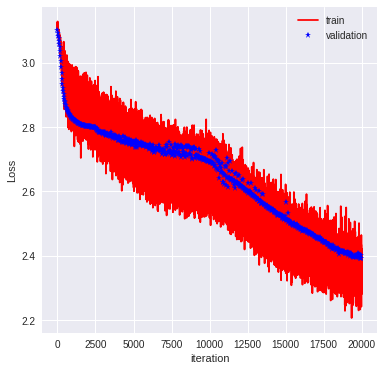

In [59]:

# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 25 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

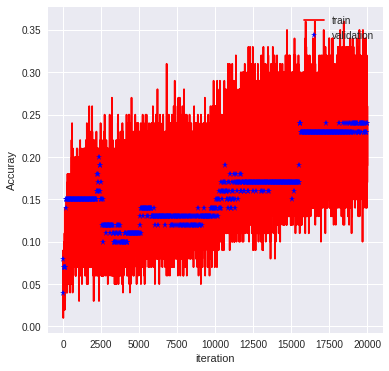

In [60]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 25 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [45]:
%%bash
cd checkpoints
ls

checkpoint
lstm2.ckpt.data-00000-of-00001
lstm2.ckpt.index
lstm2.ckpt.meta
lstm.ckpt.data-00000-of-00001
lstm.ckpt.index
lstm.ckpt.meta


### T2T for Human Walking Activity

In [0]:
# Install deps
!pip install -q -U tensor2tensor tensorflow

In [0]:
import tensorflow as tf
from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics

import os
import numpy as np

# Enable TF Eager execution
from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

# Setup some directories
data_dir = os.path.expanduser("~/t2t/data")
tmp_dir = os.path.expanduser("~/t2t/tmp")
train_dir = os.path.expanduser("~/t2t/train")
checkpoint_dir = os.path.expanduser("~/t2t/checkpoints")
tf.gfile.MakeDirs(data_dir)
tf.gfile.MakeDirs(tmp_dir)
tf.gfile.MakeDirs(train_dir)
tf.gfile.MakeDirs(checkpoint_dir)
gs_data_dir = "gs://tensor2tensor-data"
gs_ckpt_dir = "gs://tensor2tensor-checkpoints/"

#### Testing on existing problem set

In [6]:
%%bash

PROBLEM=sentiment_imdb
MODEL=transformer
HPARAMS=transformer_base_single_gpu

DATA_DIR=$HOME/t2t_data
OUT_DIR=$HOME/t2t_out
TMP_DIR=/tmp/t2t_datagen
TRAIN_DIR=$HOME/t2t_train/$PROBLEM/$MODEL-$HPARAMS

mkdir -p $DATA_DIR $TMP_DIR $TRAIN_DIR

# Generate data
t2t-datagen --problem=$PROBLEM --data_dir=$DATA_DIR --tmp_dir=$TMP_DIR

100% completed


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:Generating problems:
    sentiment:
      * sentiment_imdb
[2018-04-22 15:05:55,848] Generating problems:
    sentiment:
      * sentiment_imdb
INFO:tensorflow:Generating data for sentiment_imdb.
[2018-04-22 15:05:55,849] Generating data for sentiment_imdb.
INFO:tensorflow:Generating vocab file: /content/t2t_data/sentiment_imdb.vocab.8192
[2018-04-22 15:05:55,850] Generating vocab file: /content/t2t_data/sentiment_imdb.vocab.8192
INFO:tensorflow:Downloading http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz to /tmp/t2t_datagen/aclImdb_v1.tar.gz
[2018-04-22 15:05:55,850] Downloading http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz to /tmp/t2t_data

### **Defining the problem for Sensor data**

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gzip
import os
import random
import zipfile
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
# Dependency imports

import numpy as np

from tensor2tensor.data_generators import generator_utils
from tensor2tensor.data_generators import image_utils
from tensor2tensor.utils import registry
from tensor2tensor.data_generators import problem

import tensorflow as tf

### Prepare data

Get data from UCI URL, unzip, read, scale, create windows, and generate data

In [0]:
DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00286/User%20Identification%20From%20Walking%20Activity.zip'
filename = 'User Identification From Walking Activity.zip'
folder = 'User Identification From Walking Activity'
tmp_dir = '.'

def _get_data(directory):
    generator_utils.maybe_download(directory, filename, DATA_URL)

def _scale_data(data):
  X=data[['x','y','z']]
  scaler=MinMaxScaler()
  scaler.fit(X)
  X_scaled = pd.DataFrame(scaler.transform(X))
  X_scaled.columns = ['x_scaled', 'y_scaled', 'z_scaled']
  return X_scaled.join(data['label'])

def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)
        
def window_signals(data,window_size = 500):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data["x_scaled"], window_size):
        x = data["x_scaled"][start:end]
        y = data["y_scaled"][start:end]
        z = data["z_scaled"][start:end]
        if(len(data["x_scaled"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["label"][start:end])[0][0])
    return segments, labels

def _read_and_transform(directory):
  _get_data(directory) #Remove comment to execute first time.
  zip_ref = zipfile.ZipFile(directory + '/' + filename, 'r')
  zip_ref.extractall(directory)
  zip_ref.close()
  data = pd.DataFrame()
  for i in range(1,23):
    df = pd.read_csv(str(directory)+ '/' + str(folder) + '/%s.csv' % i,header=None)
    df.columns = ['time_step','x','y', 'z']
    df['label'] = i
    data = data.append(df)
  data = data.reset_index().drop('index', axis=1)
  data = _scale_data(data)
  return window_signals(data)

### Call functions to generate data
Create the data depending on if its for a train or validation shard

In [0]:
def activity_generator(tmp_dir, training, data_dir):
  """Sensor generator.
  Args:
    tmp_dir: path to temporary storage directory.
    training: a Boolean; if true, we use the train set, otherwise the test set.

  Returns:
    A generator for sensor readings with labels depending on train or dev.
  """
  del data_dir
  X=_read_and_transform(tmp_dir)[0]
  y=_read_and_transform(tmp_dir)[1]
  X_train, X_vld, y_train, y_vld = train_test_split(X, y, 
                                                stratify = y,
                                                random_state = 123)
  if training:
    X=X_train
    y=y_train
  else:
    X=X_vld
    y=y_vld
  
  for i in range(0,X.shape[0]):
    yield {"input": X[i],
          "label": y[i]}
  

#### Some Test

Check to see if the functions provide the desired output

In [13]:
_get_data('.')

INFO:tensorflow:Downloading https://archive.ics.uci.edu/ml/machine-learning-databases/00286/User%20Identification%20From%20Walking%20Activity.zip to ./User Identification From Walking Activity.zip


[2018-04-23 01:55:31,459] Downloading https://archive.ics.uci.edu/ml/machine-learning-databases/00286/User%20Identification%20From%20Walking%20Activity.zip to ./User Identification From Walking Activity.zip


100% completed
INFO:tensorflow:Successfully downloaded User Identification From Walking Activity.zip, 1316158 bytes.


[2018-04-23 01:55:32,245] Successfully downloaded User Identification From Walking Activity.zip, 1316158 bytes.


In [19]:
_read_and_transform('.')

(array([[[0.52118089, 0.46227374, 0.65515252],
         [0.50717019, 0.47254722, 0.70674183],
         [0.49561153, 0.42207831, 0.70197827],
         ...,
         [0.42450753, 0.6610244 , 0.41626198],
         [0.42660855, 0.65968324, 0.41745244],
         [0.42555933, 0.65834536, 0.41864289]],
 
        [[0.43641671, 0.67620999, 0.4253891 ],
         [0.43816798, 0.67710192, 0.42777001],
         [0.44517307, 0.66995672, 0.42102409],
         ...,
         [0.45498123, 0.57036005, 0.3797541 ],
         [0.41750244, 0.63333224, 0.37300644],
         [0.36636322, 0.68469635, 0.38173819]],
 
        [[0.4273106 , 0.6610244 , 0.41626198],
         [0.42941161, 0.66236556, 0.41626198],
         [0.43256442, 0.66325748, 0.41745244],
         ...,
         [0.40174099, 0.65342996, 0.45316697],
         [0.38808054, 0.70255115, 0.4297541 ],
         [0.40279278, 0.75750918, 0.3952306 ]],
 
        ...,
 
        [[0.45708224, 0.55919465, 0.44562742],
         [0.4728437 , 0.55919465, 0.41308

In [0]:
X=_read_and_transform('.')[0]
y=_read_and_transform('.')[1]

### Creating a custom problem
Inherit the problem class from the T2T and register the new problem

In [0]:
@registry.register_problem
class HumanWalkingActivity500(problem.Problem):
  """Problem spec for walking activity person predictor problem."""

  @property
  def num_shards(self):
    return 5

  def feature_encoders(self, data_dir):
    raise NotImplementedError()

  def generate_data(self, data_dir, tmp_dir, task_id=-1):
    generator_utils.generate_dataset_and_shuffle(activity_generator(tmp_dir, 1, data_dir),
        self.training_filepaths(data_dir, self.num_shards, shuffled=False),
        activity_generator(tmp_dir, 0, data_dir),
        self.dev_filepaths(data_dir, 1, shuffled=False))

  def hparams(self, defaults, unused_model_hparams):
    p = defaults
    p.input_modality = {
        "inputs": (registry.Modalities.REAL)
    }
    p.target_modality = (registry.Modalities.CLASS_LABEL)

### Store and run the above

In [35]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving __init__.py to __init__.py
User uploaded file "__init__.py" with length 35 bytes


In [40]:
!ls * -r

User Identification From Walking Activity.zip  humanwalkingactivity.py
__init__.py

User Identification From Walking Activity:
README	7.csv  4.csv  22.csv  1.csv   17.csv  14.csv  11.csv
9.csv	6.csv  3.csv  21.csv  19.csv  16.csv  13.csv  10.csv
8.csv	5.csv  2.csv  20.csv  18.csv  15.csv  12.csv

t2t:
train  tmp  data  checkpoints

__MACOSX:
User Identification From Walking Activity

humanwalkingactivity:
__init__.py  humanwalkingactivity.py

datalab:


In [39]:
%%bash
mkdir humanwalkingactivity
cp humanwalkingactivity.py ./humanwalkingactivity/humanwalkingactivity.py
cp __init__.py ./humanwalkingactivity/__init__.py

mkdir: cannot create directory ‘humanwalkingactivity’: File exists


In [42]:
%%bash


USR_DIR=./humanwalkingactivity
PROBLEM=human_walking_activity500
DATA_DIR=$HOME/t2t_data
TMP_DIR=/tmp/t2t_datagen
mkdir -p $DATA_DIR $TMP_DIR

t2t-datagen \
  --t2t_usr_dir=$USR_DIR \
  --data_dir=$DATA_DIR \
  --tmp_dir=$TMP_DIR \
  --problem=$PROBLEM

100% completed


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:Importing user module humanwalkingactivity from path /content
[2018-04-23 02:41:26,398] Importing user module humanwalkingactivity from path /content
INFO:tensorflow:Generating problems:
    human:
      * human_walking_activity500
[2018-04-23 02:41:26,706] Generating problems:
    human:
      * human_walking_activity500
INFO:tensorflow:Generating data for human_walking_activity500.
[2018-04-23 02:41:26,706] Generating data for human_walking_activity500.
INFO:tensorflow:Downloading https://archive.ics.uci.edu/ml/machine-learning-databases/00286/User%20Identification%20From%20Walking%20Activity.zip to /tmp/t2t_datagen/User Identification From Walking Activity.zip
[2018-04